<a href="https://colab.research.google.com/github/Santiago-Quinteros/Google_Cloud_Platform-TP/blob/main/Google_Cloud_Platform_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Before starting:**

You need to install Basemap. You have to do it at each new session.

In [ ]:
!pip install basemap

**Goal of this practice:**

The goal is to use a cloud computing platform (the Google Cloud Platform). We will use big data tools on Colab to process large datasets. These data are real satellite observations of the ocean (5 years).

**Evaluation of this practice:**

I will evaluate 3 main components.

The first is the quality of the code. It must be concise and well written. The goal is to manipulate big data tools provided by the Google Cloud Platform (such as BigQuery).

The second is the quality of the outputs. Never forget that you are dealing with physical variables evolving in space and time. You must use maps and time series. You must also write the units (e.g., °C, m).

The third thing is the discussion about your results. Again, remember that you are dealing with oceanographic data. They have a physical meaning and you should be able to comment the outputs.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [ ]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [ ]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**The satellite database:**

In this practice, we use 5 years (2011-2015) of satellite observations of the global ocean. We use daily data with 25km spatial resolution. We study the Sea Surface Temperature (SST, in degrees) and the Sea Surface Height (SSH, in meters). SST and SSH are indexed in space (lon, lat) and time. The full database is stored in csv files and is quite large (~50Go).

**Part 1) Manipulation of a small dataset using pandas:**

We start to work on a small database (only the 10 first days in 2015, ~250Mo) and we will perform some basic statistics. The idea is to show that even if you use a small sample, basic data manipulation without big data tools is difficult, time and resource consuming.

After copying the dataset "data_sst_ssh_2015_small.csv" on your Colab environment, we read it using pandas (easy-to-use data structures and data analysis tools). We use the *groupby* and *mean* pandas functions to: map the global SST and SSH (using *plot_im*), plot the mean SST and SSH time series (using *plot_ts*).

In [ ]:
# read dataframe
data = pd.read_csv('data_sst_ssh_2015_small.csv', header=None, names=['lat', 'lon', 'sst', 'time', 'ssh'])

In [ ]:
# sample of the dataset
data

lat     lon   sst      time     ssh
0         1.000     NaN   NaN       NaN     NaN
1       -52.375  84.375  2.10  735601.0 -0.9074
2       -52.375  84.625  2.25  735601.0 -0.9137
3       -52.375  84.875  2.10  735601.0 -0.9165
4       -52.375  85.125  2.25  735601.0 -0.9083
...         ...     ...   ...       ...     ...
4715707  81.875  29.375 -1.80  735609.0 -0.3426
4715708  81.875  29.625 -1.80  735609.0 -0.3394
4715709  81.875  29.875 -1.80  735609.0 -0.3377
4715710  81.875  30.125 -1.80  735609.0 -0.3370
4715711  81.875  30.375 -1.80  735609.0     NaN

[4715712 rows x 5 columns]

In [ ]:
# statistics of the dataset
data.describe()

lat           lon           sst          time           ssh
count  4.715712e+06  4.715711e+06  4.715711e+06  4.715711e+06  4.715710e+06
mean  -1.046896e+01  1.934771e+02  1.675601e+01  7.356051e+05  3.669521e-01
std    3.821052e+01  1.002551e+02  1.029159e+01  2.545924e+00  7.091401e-01
min   -7.737500e+01  1.250000e-01 -1.800000e+00  7.356010e+05 -1.520300e+00
25%   -4.312500e+01  1.128750e+02  7.050000e+00  7.356030e+05  4.770000e-02
50%   -1.462500e+01  1.973750e+02  1.995000e+01  7.356050e+05  5.809000e-01
75%    1.812500e+01  2.733750e+02  2.595000e+01  7.356070e+05  8.593000e-01
max    8.437500e+01  3.598750e+02  3.240000e+01  7.356090e+05  1.895600e+00

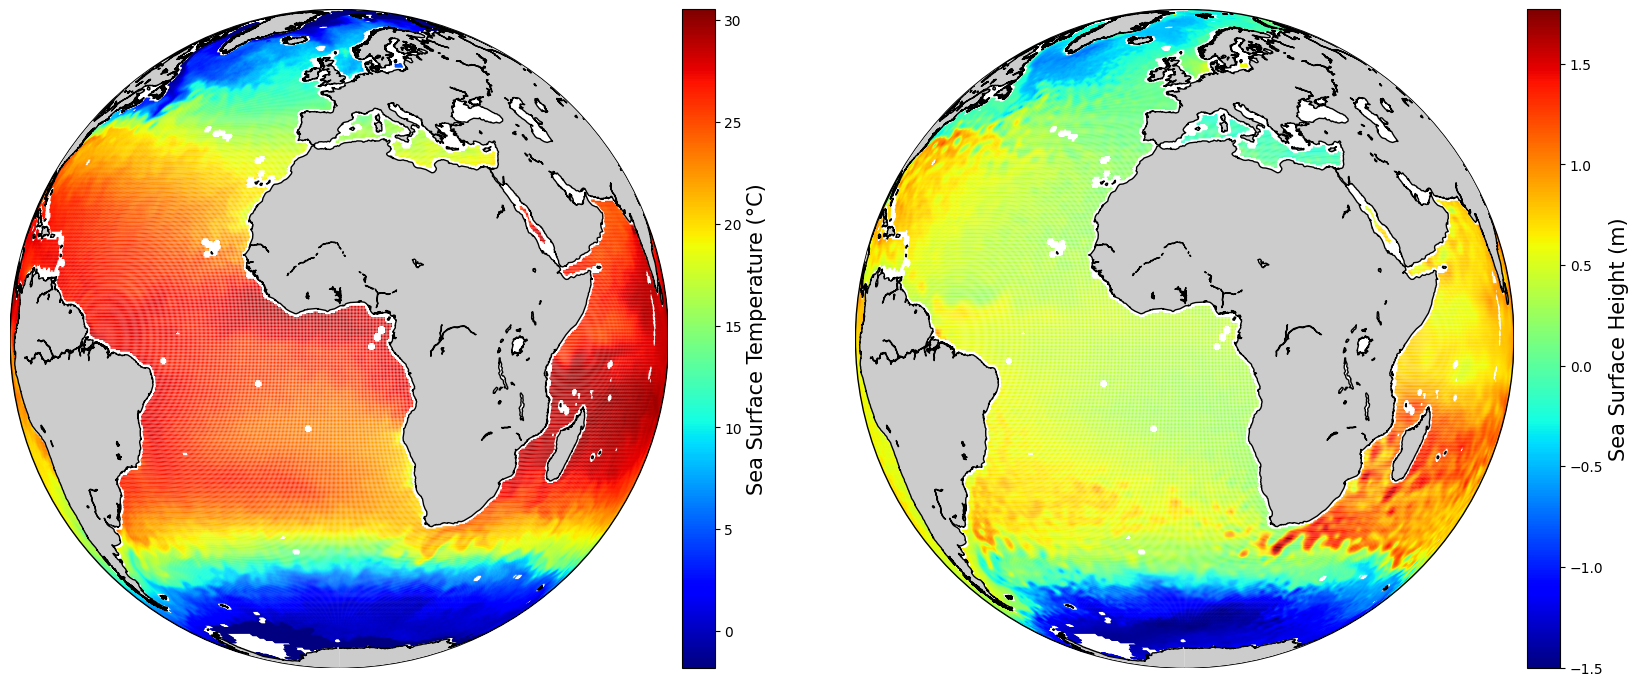

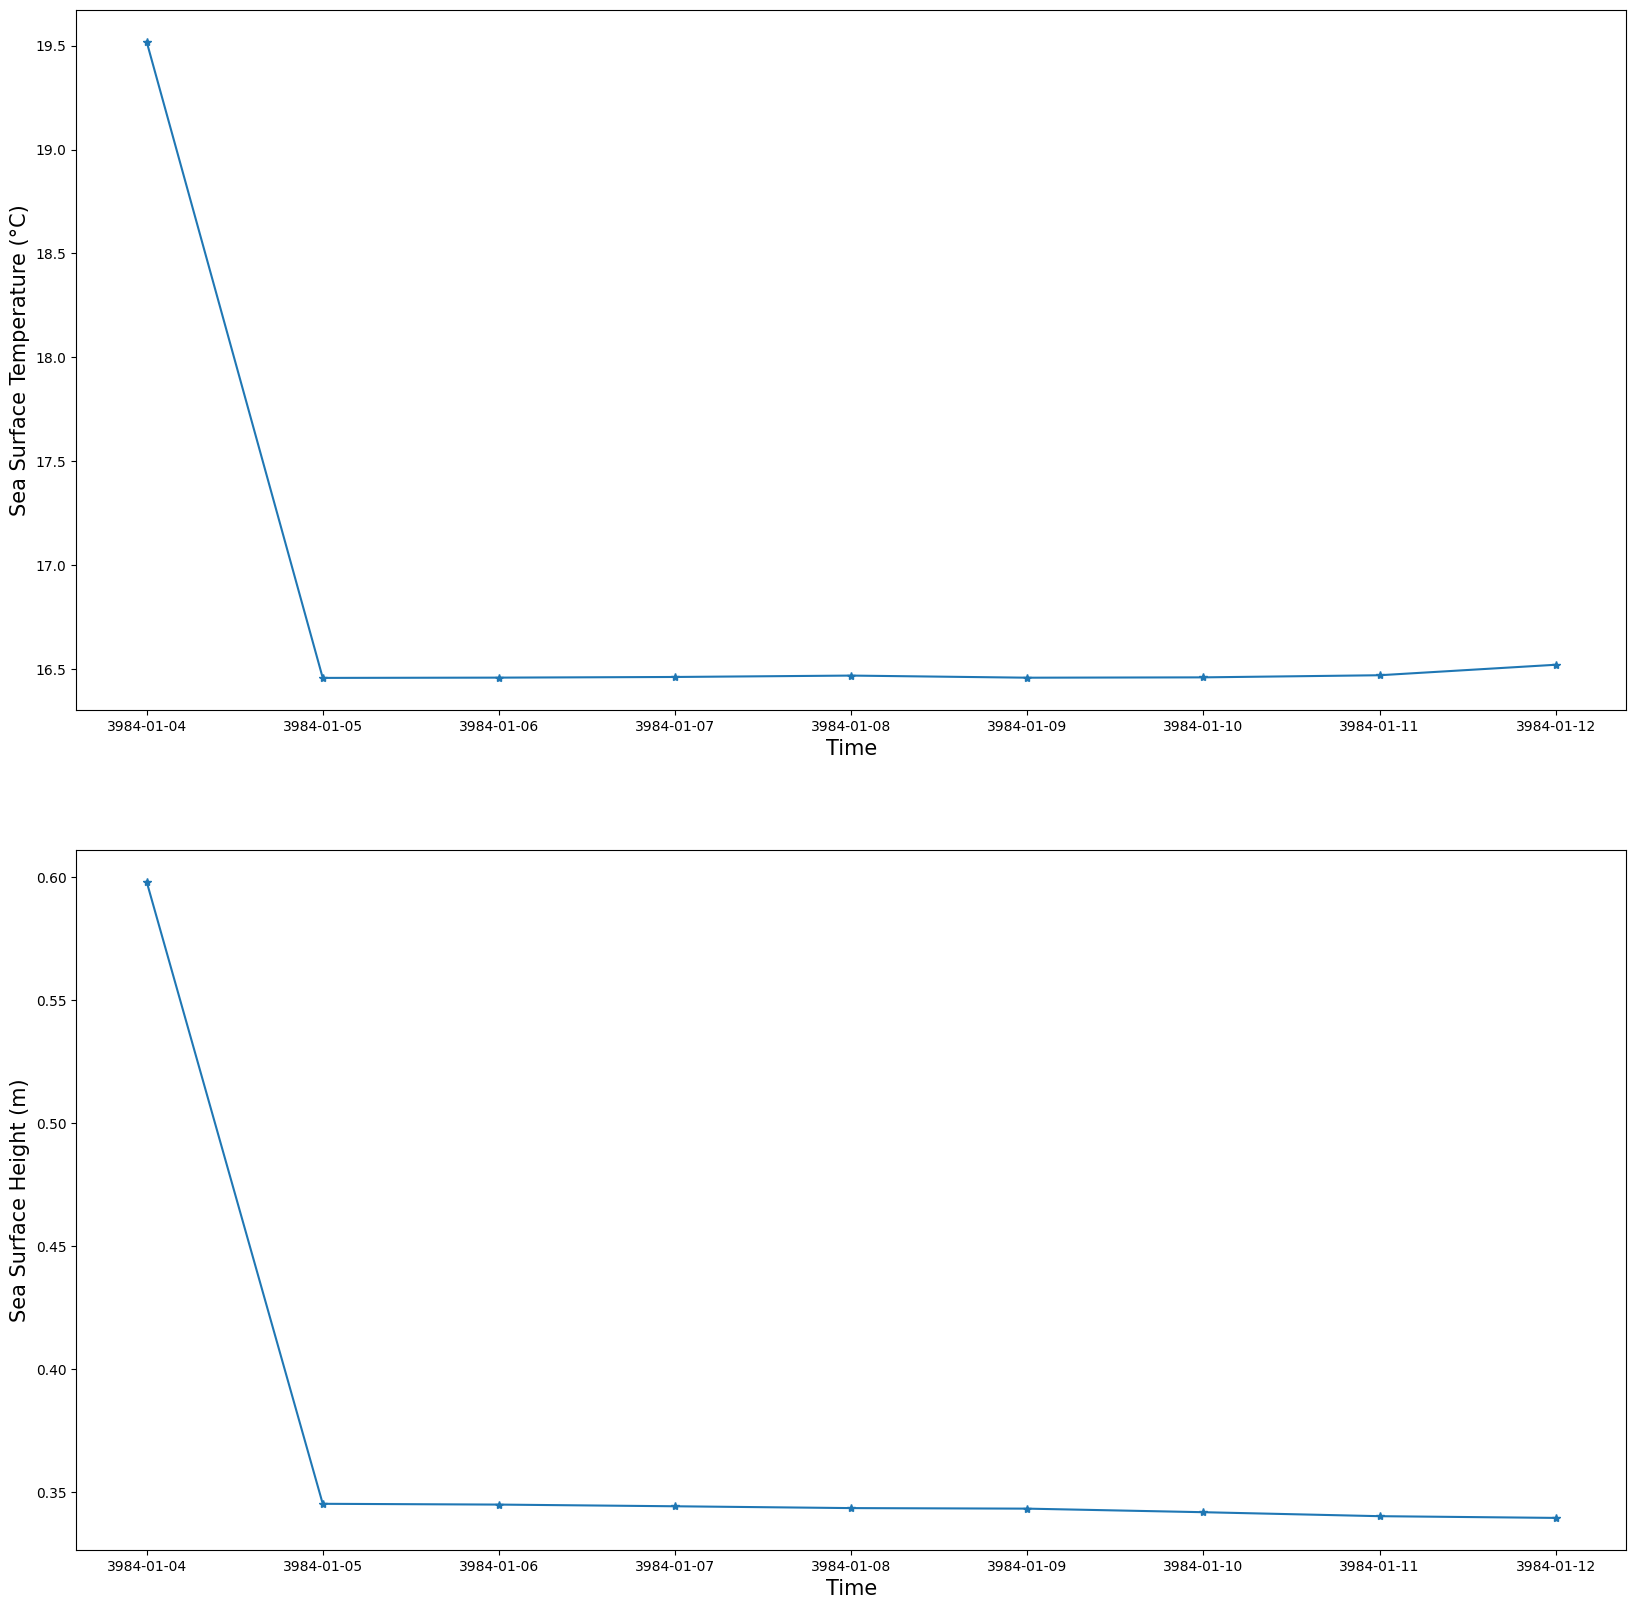

In [ ]:
# plot global SST and SSH maps
sst_im=data.groupby(['lon','lat'])['sst'].mean()
ssh_im=data.groupby(['lon','lat'])['ssh'].mean()
lon_im=data.groupby(['lon','lat'])['lon'].mean()
lat_im=data.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_im,lat_im,sst_im,1,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_im,lat_im,ssh_im,1,'Sea Surface Height (m)')

# plot global SST and SSH time series
sst_ts=data.groupby(['time'])['sst'].mean()
ssh_ts=data.groupby(['time'])['ssh'].mean()
time_ts=data.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_ts,sst_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_ts,ssh_ts,'-*','Sea Surface Height (m)')

Now, we consider only a small region of the Globe: the Mediterranean Sea. As previously, we plot the mean time series and maps of SST and SSH. We also plot the SSH as a function of SST and the 2 distributions using histograms.

Text(0, 0.5, 'Sea Surface Height (m)')

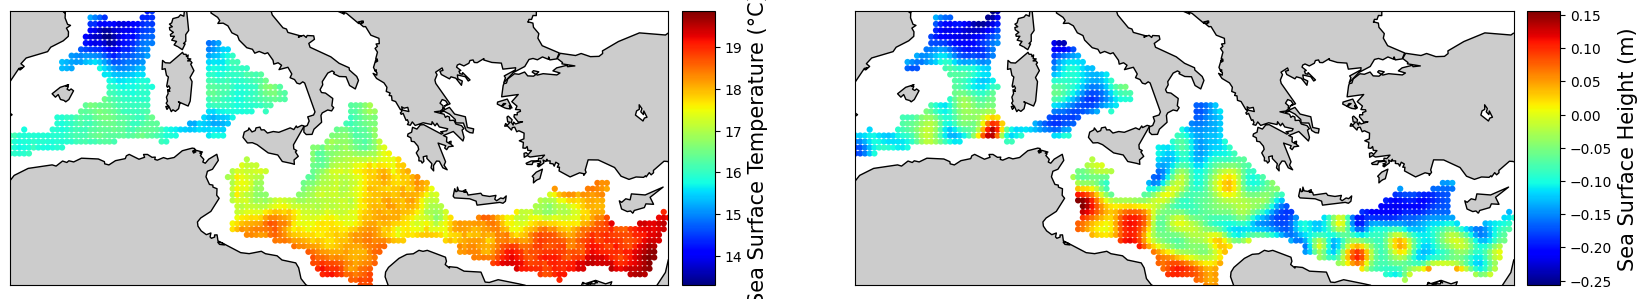

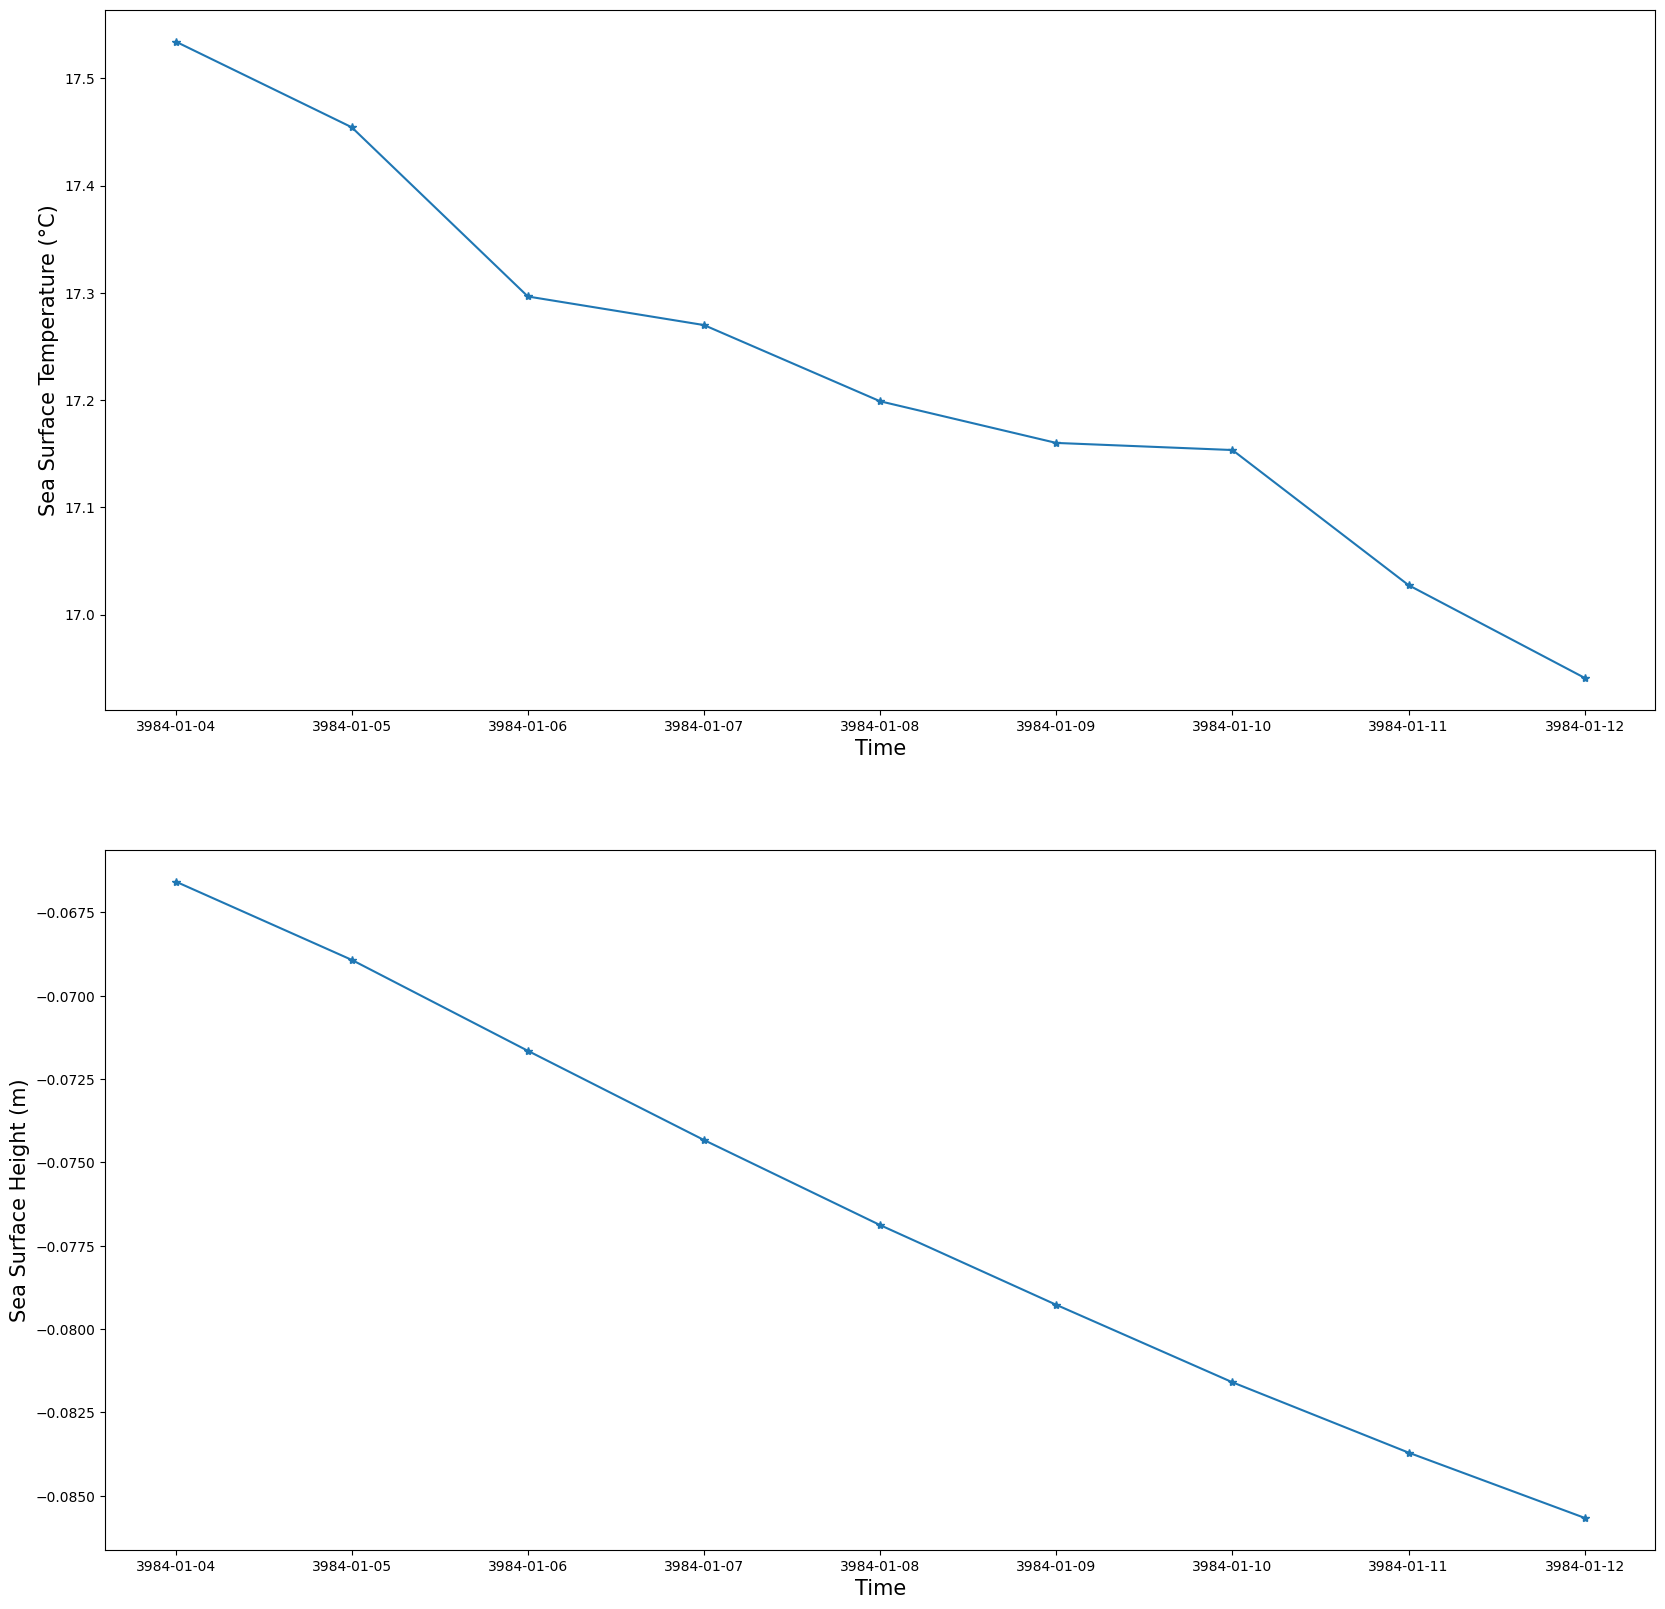

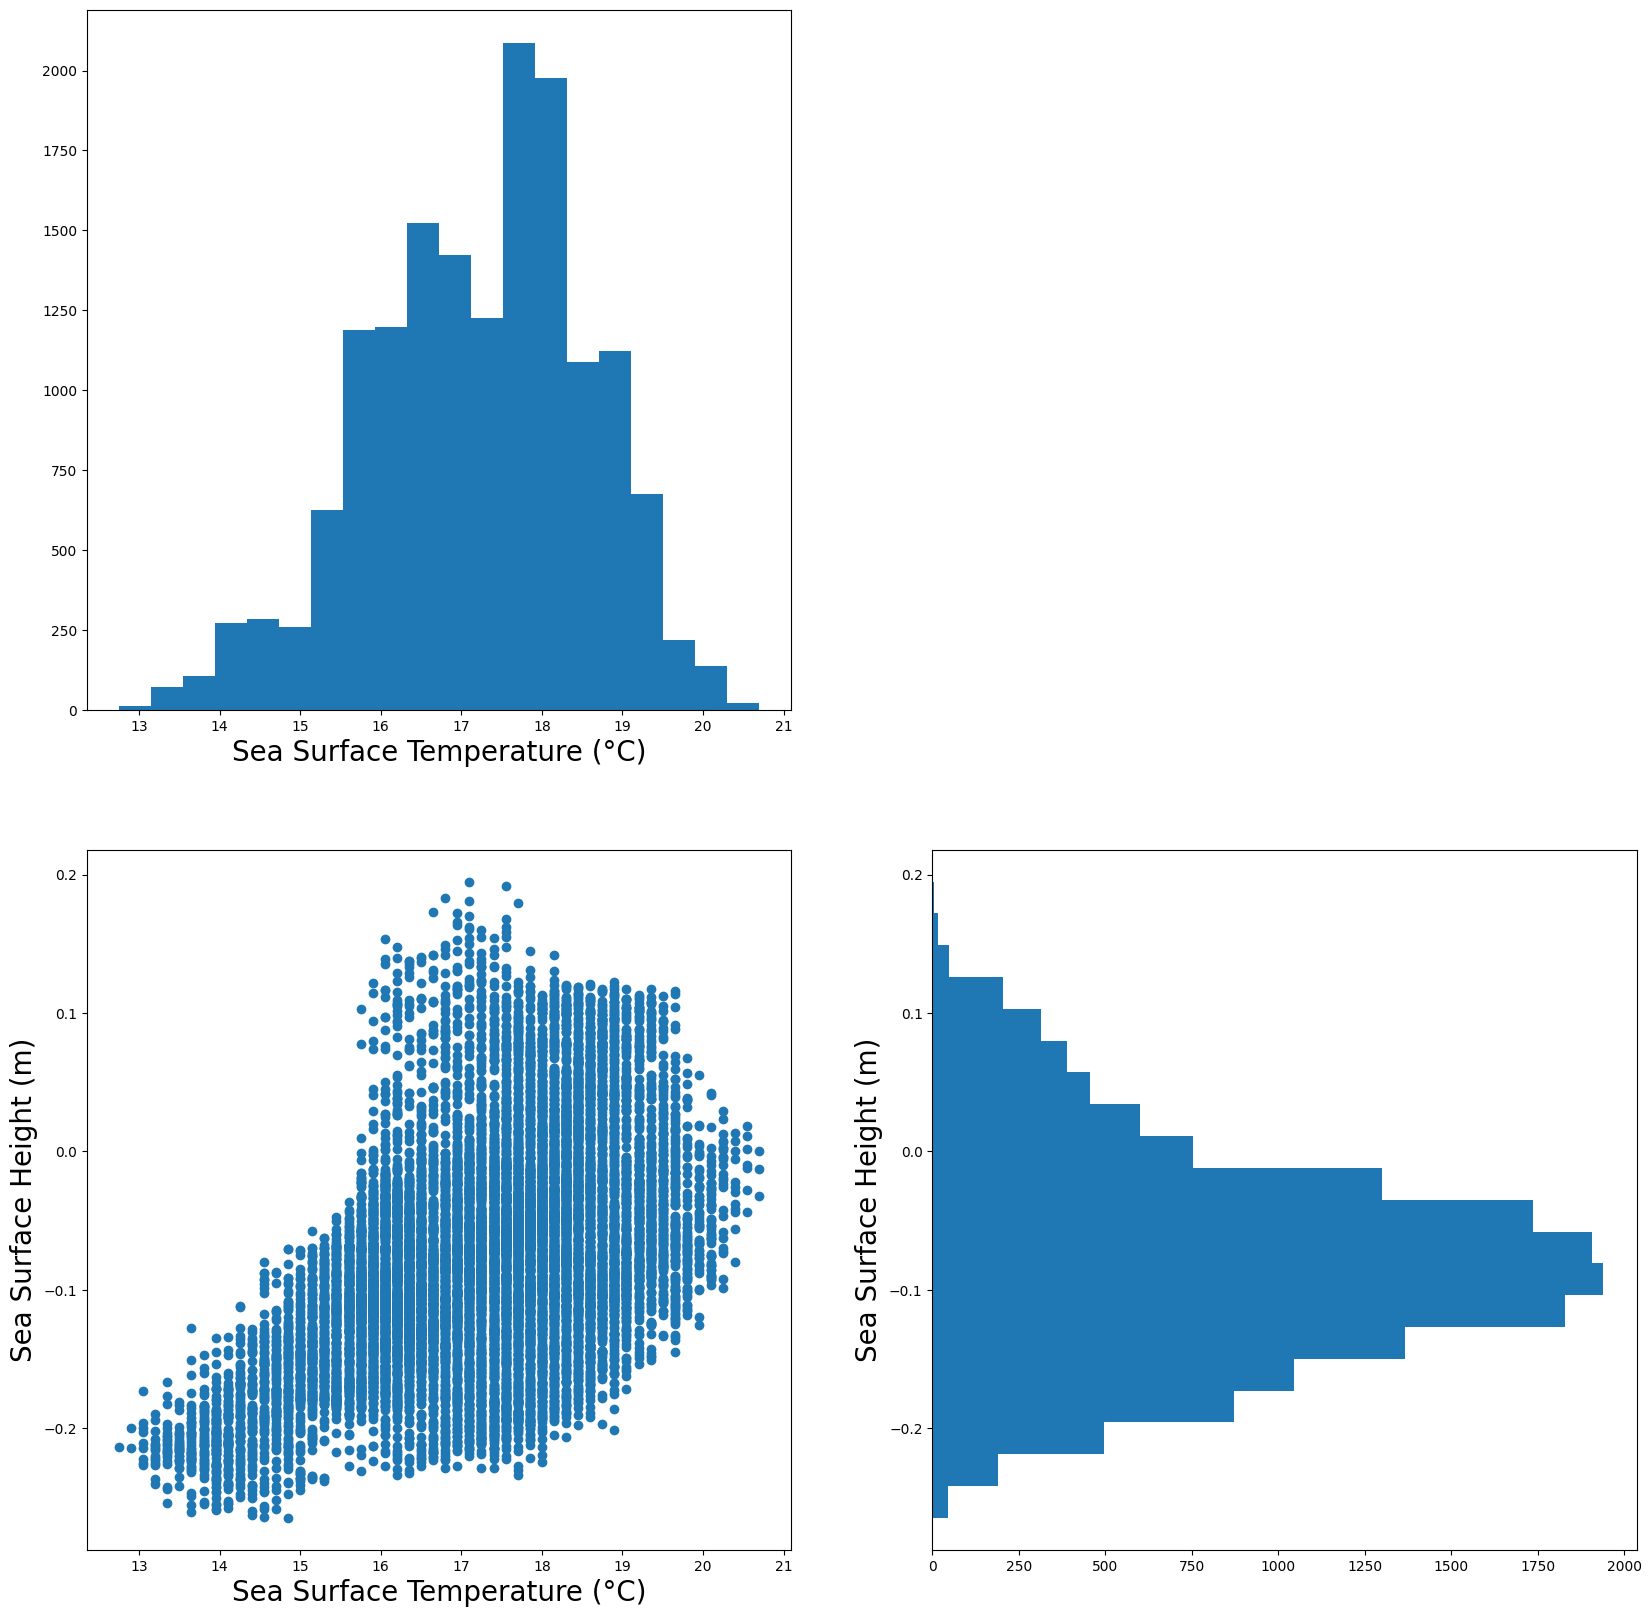

In [ ]:
# data selection
data_med=data[(data.lon>0) & (data.lon<35) & (data.lat>30) & (data.lat<45)]

# plot SST and SSH maps
sst_med_im=data_med.groupby(['lon','lat'])['sst'].mean()
ssh_med_im=data_med.groupby(['lon','lat'])['ssh'].mean()
lon_med_im=data_med.groupby(['lon','lat'])['lon'].mean()
lat_med_im=data_med.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_med_im,lat_med_im,sst_med_im,20,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_med_im,lat_med_im,ssh_med_im,20,'Sea Surface Height (m)')

# plot SST and SSH time series
sst_med_ts=data_med.groupby(['time'])['sst'].mean()
ssh_med_ts=data_med.groupby(['time'])['ssh'].mean()
time_med_ts=data_med.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_med_ts,sst_med_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_med_ts,ssh_med_ts,'-*','Sea Surface Height (m)')

# plot hist(SST), hist(SSH), SSH~SST
figure()
subplot(2,2,1)
hist(data_med.sst, 20)
xlabel('Sea Surface Temperature (°C)', size=20)
subplot(2,2,4)
hist(data_med.ssh, 20, orientation=u'horizontal')
ylabel('Sea Surface Height (m)', size=20)
subplot(2,2,3)
scatter(data_med.sst, data_med.ssh)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)

**Remark:**

The dataset used above is small (250Mo) and corresponds only to 10 days. Now, we want to manipulate the full database of 5 years (50Go) using big data tools. This database is stored in the Google Cloud Platform.

**Part 2) Manipulation of the full database using BigQuery**

First, we have to connect to the Google Cloud Platform using the following command. You will have to enter the login "bigdataocean2020@gmail.com". Send me an email to get the password (pierre.tandeo@imt-atlantique.fr). Then, copy/paste the authentification code in the following cell.

In [ ]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntax in BigQuery is very similar to the pandas example given in Part 1). For instance, in the example below, we plot the mean SST map in the Mediterranean Sea over the period 2011-2015. The full 5-years dataset is stored in the BigQuery table *bdo2020.bdo2020.2011_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe.

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# sample of the dataframe
output

lon     lat   mean_sst
0     28.625  31.875  22.554874
1     26.875  32.125  22.701013
2     33.375  32.125  23.362623
3     16.375  32.375  22.581407
4     17.125  32.375  22.400602
...      ...     ...        ...
1718   7.625  41.625  18.786062
1719   7.125  41.875  18.471030
1720   5.875  42.125  17.801533
1721   7.375  42.125  18.472508
1722   7.375  42.375  18.416402

[1723 rows x 3 columns]

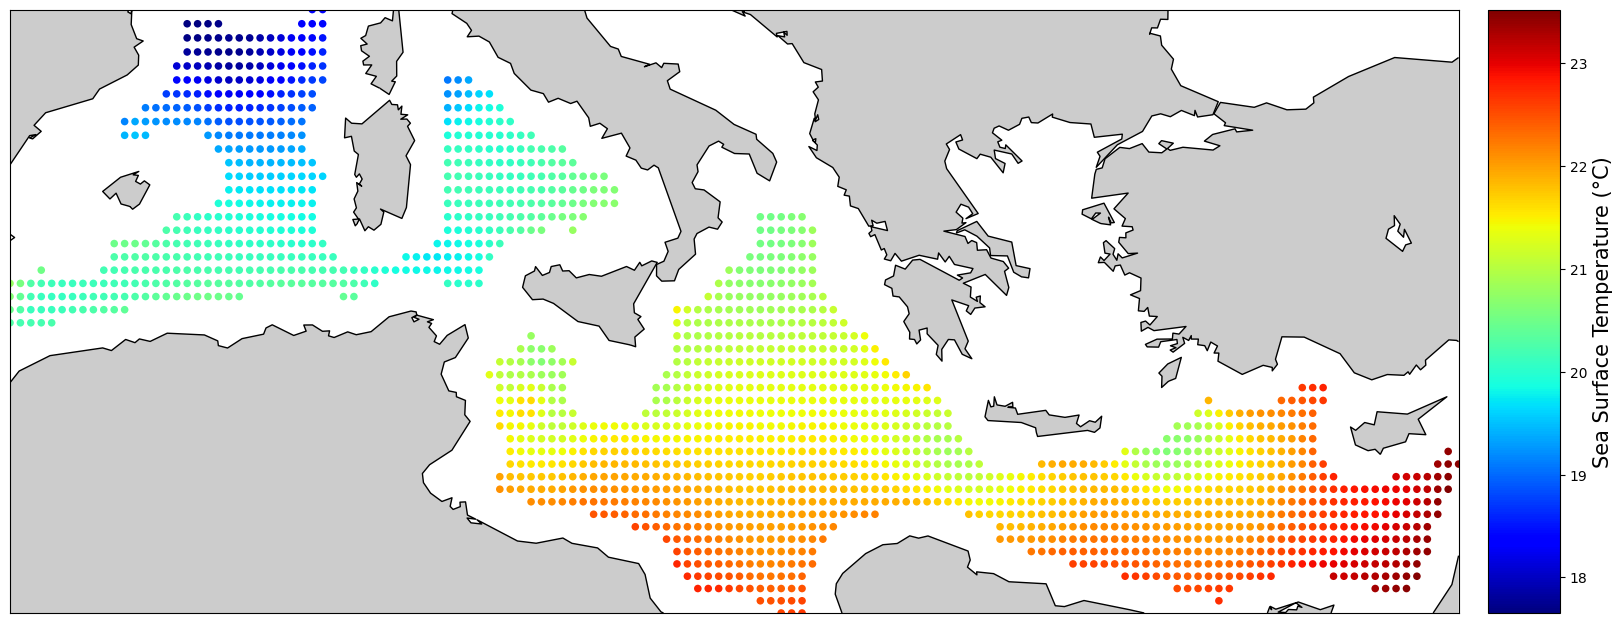

In [ ]:
plot_im(output.lon,output.lat,output.mean_sst,30,'Sea Surface Temperature (°C)')

SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

The idea here is to extract the results of BigQuery and then use scikit-learn to perform some analysis: https://scikit-learn.org/stable/.

**Important note:** the tables stored in the Google Cloud Platform are not chronologically ordered. When dealing with time series, you will thus have to use *ORDER BY time* in your BigQuery requests.

**QUESTION 1**: Compute and plot the correlation map between SST and SSH, over the period 2011-2015, in the Agulhas current, between longitudes (+15,+70) and latitudes (-50,-30).

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT sst, ssh
FROM bdo2020.bdo2020.2011_2015
WHERE lon>15 AND lon<70 AND lat>-50 AND lat<-30


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output

sst     ssh
0         25.50  0.9101
1          9.30  0.0644
2         11.55 -0.0541
3         12.45  0.2716
4          8.70 -0.0179
...         ...     ...
30070563  19.80  0.9429
30070564  19.80  1.0091
30070565  19.80  1.1247
30070566  19.80  1.3746
30070567  19.80  1.2052

[30070568 rows x 2 columns]

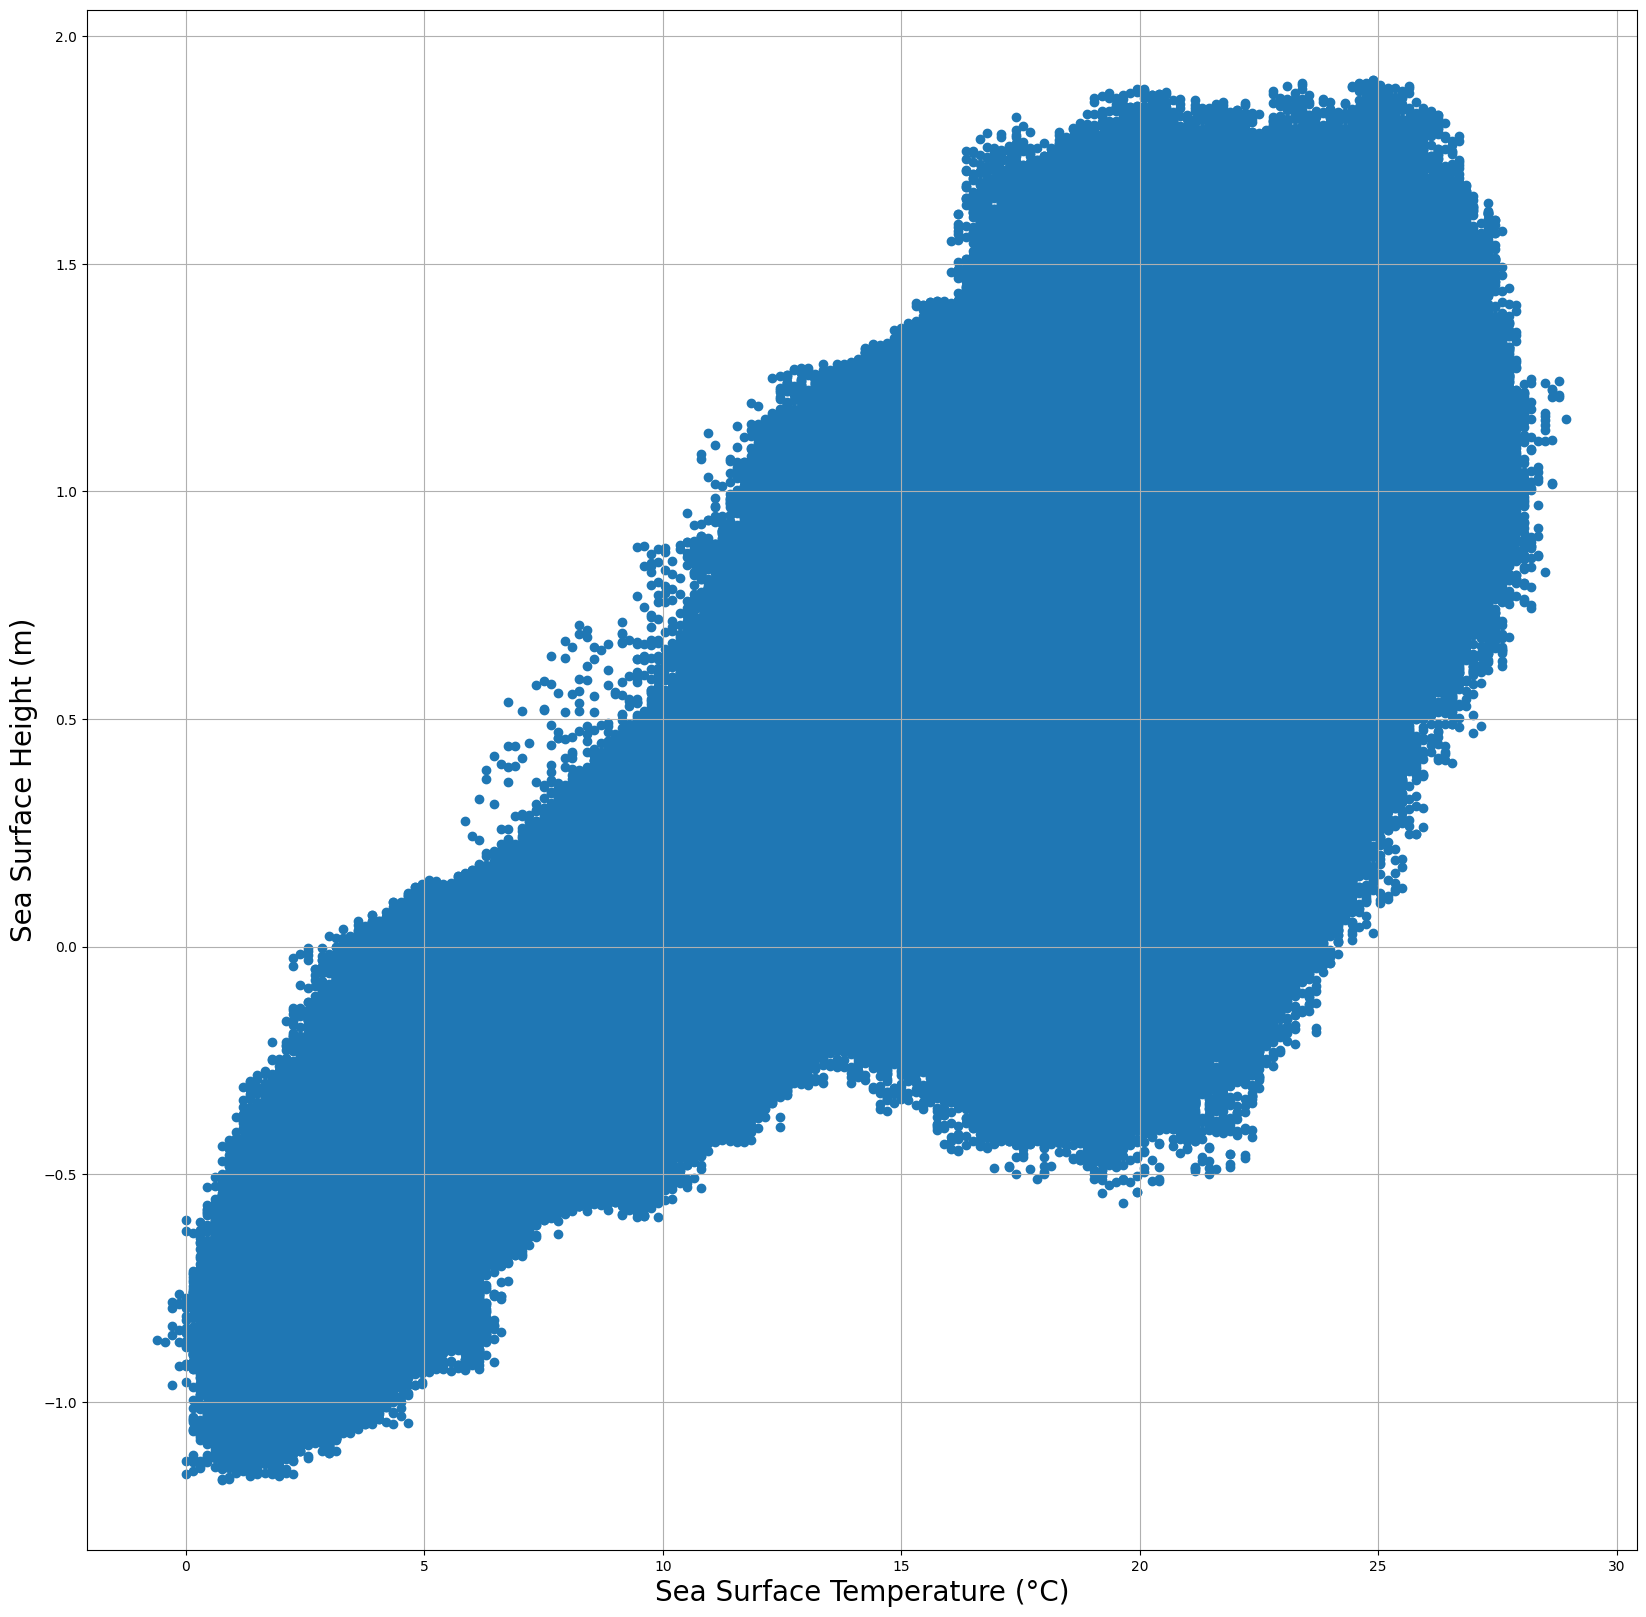

In [ ]:
figure()
scatter(output.sst, output.ssh)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)
plt.grid()

**Note 1:** From the correlation map we see the same relation between SST and SSH as in the Mediterranean sea which suggests that this may be related to the  thermal expansion of seawater.

**QUESTION 2**: Plot the daily mean and daily standard deviation time series of SST for the period 2011-2015 in the Equatorial Pacific, between longitudes (+180,+300) and latitudes (-20,+20). The mean SST time series is called the ENSO index and is used to identify El Niño and La Niña events.

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst, STDDEV(sst) AS std_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output

time   mean_sst   std_sst
0     734987.0  26.981678  1.934075
1     734989.0  26.987796  1.915166
2     734995.0  27.062044  2.029866
3     734996.0  27.059761  2.033591
4     734894.0  26.150618  1.780694
...        ...        ...       ...
1821  734246.0  26.606563  1.786630
1822  734251.0  26.663061  1.795892
1823  734700.0  26.387206  2.150550
1824  735753.0  27.460161  1.998936
1825  735785.0  27.403853  2.195452

[1826 rows x 3 columns]

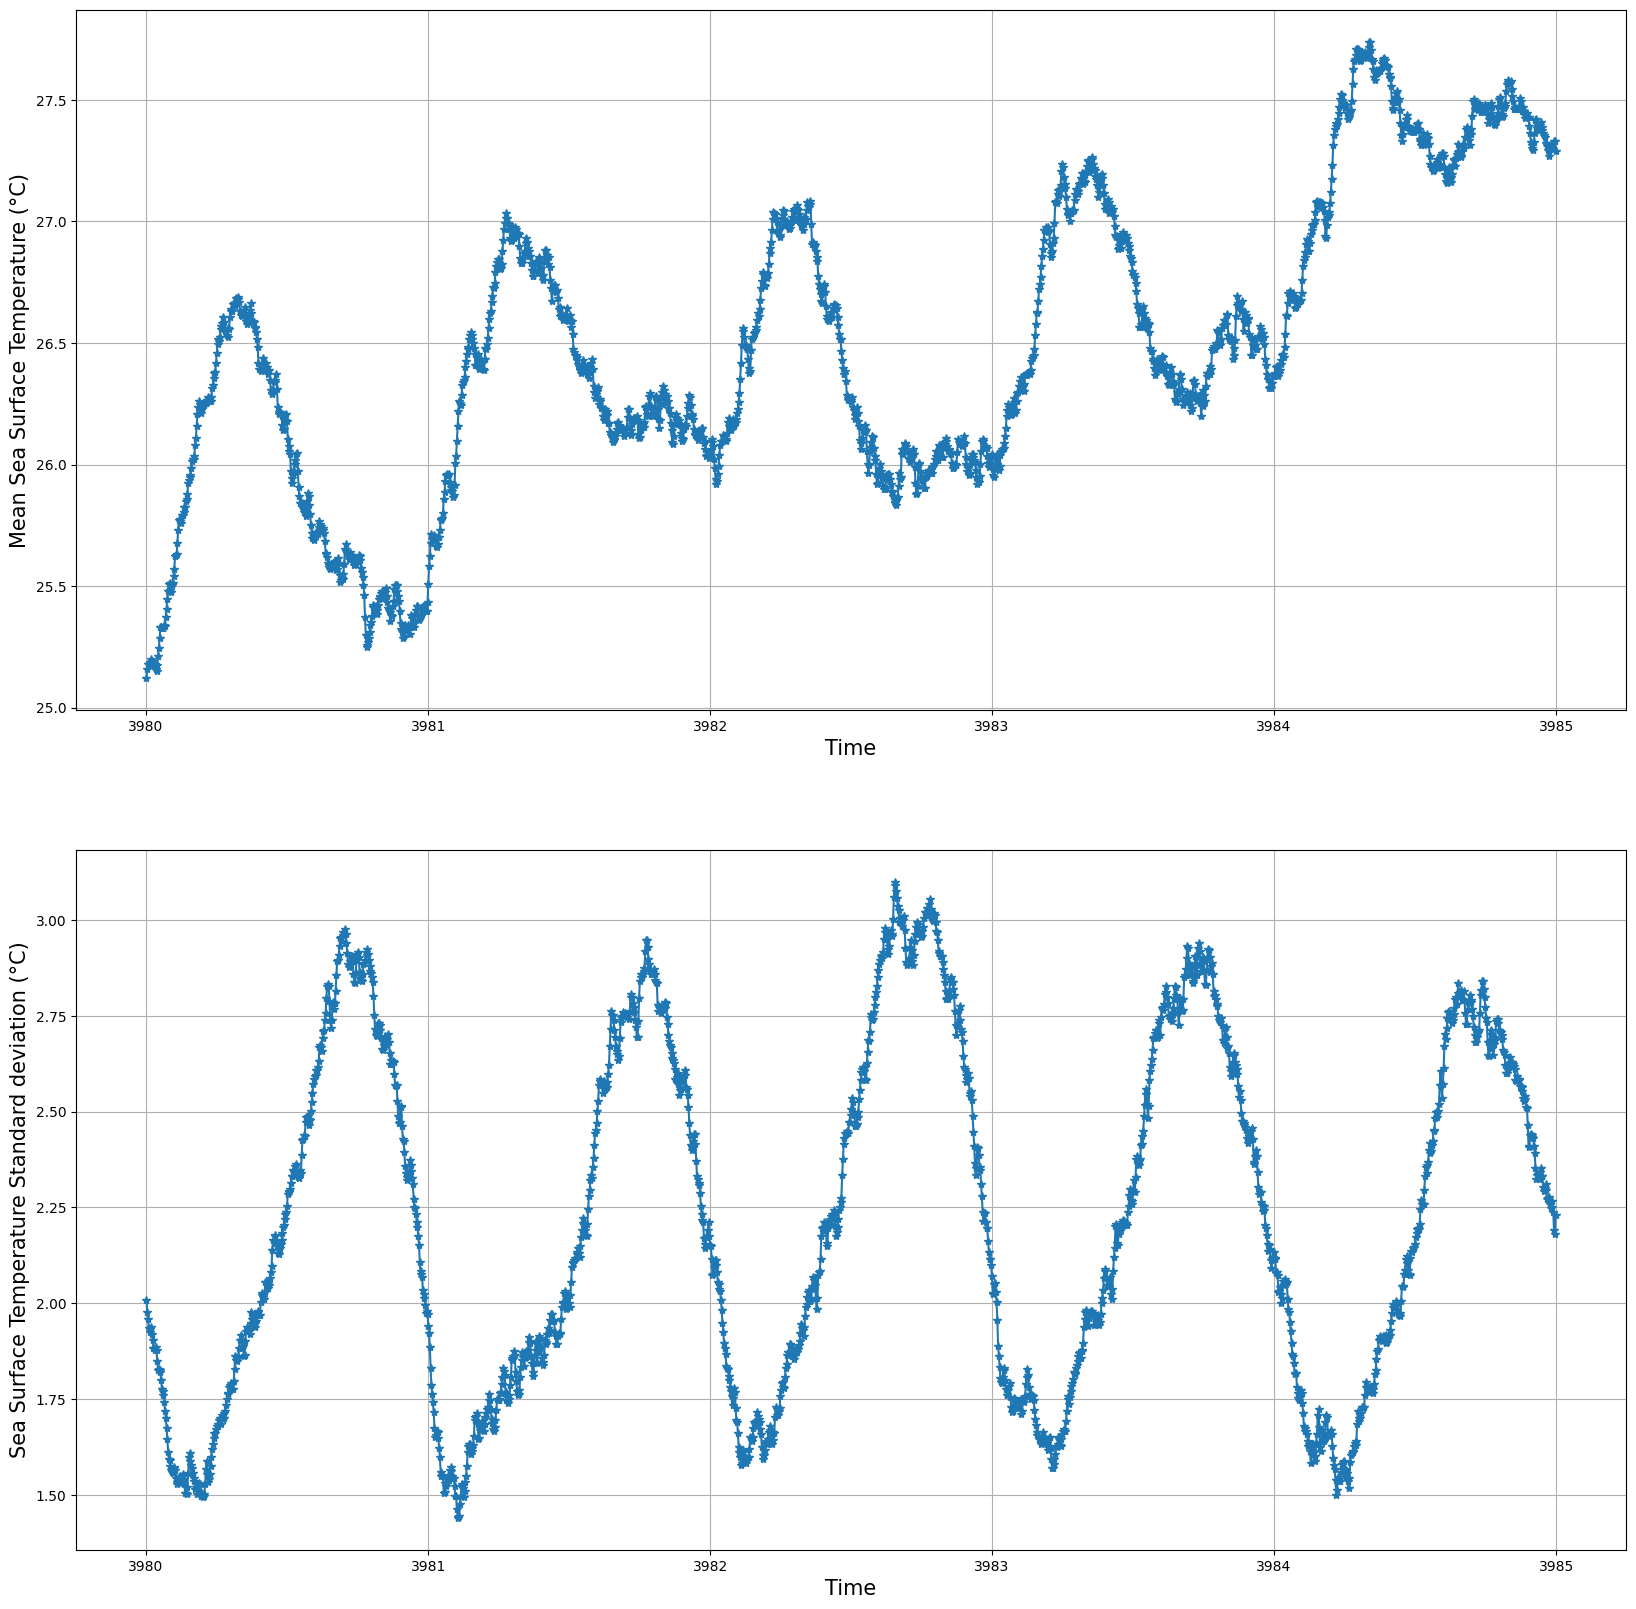

In [ ]:
# plot global SST and SSH time series
sst_mean=output.groupby(['time'])['mean_sst'].mean()
sst_std=output.groupby(['time'])['std_sst'].mean()
time_ts=output.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_ts,sst_mean,'-*','Mean Sea Surface Temperature (°C)')
plt.grid()
subplot(2,1,2)
plot_ts(time_ts,sst_std,'-*','Sea Surface Temperature Standard deviation (°C)')
plt.grid()

**Note 2:**
We can observe that the mean temperature in the region has a periodic cycle along the year, it has a peak in the first half of the year and a valley in the ending of the year. The average temperature increases every year.

From the time series graphs we observe that the standard deviation has a periodic behaviour whose peaks coincide with the local minima of the mean SST. This makes sense, as when the mean temperature over the equatorial Pacific reaches its maximum is when the warm water off the coast of South America starts travelling west. This homogenizes the region and therefore reduces the standard deviation over it.


**QUESTION 3**: Compute the daily time series of SST over the period 2011-2015 in the Pacific Ocean, south of Japan, between longitudes (+120,+145) and latitudes (+20,+40). In this region, there are a lot of typhoons and they use the energy of the sea (hot waters) to get stronger. Thus, after a typhoon, we see a rapid decrease of the SST. Plot the time series of the difference of SST between 2 consecutive days and check that the negative peaks (e.g., below -0.4°C) correspond to well known typhoons.

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>120 AND lon<145 AND lat>20 AND lat<40
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output

time   mean_sst
0     734138.0  20.681954
1     734139.0  20.496030
2     734140.0  20.455747
3     734141.0  20.402332
4     734142.0  20.315408
...        ...        ...
1821  735959.0  21.959162
1822  735960.0  21.819795
1823  735961.0  21.654470
1824  735962.0  21.683953
1825  735963.0  21.766768

[1826 rows x 2 columns]

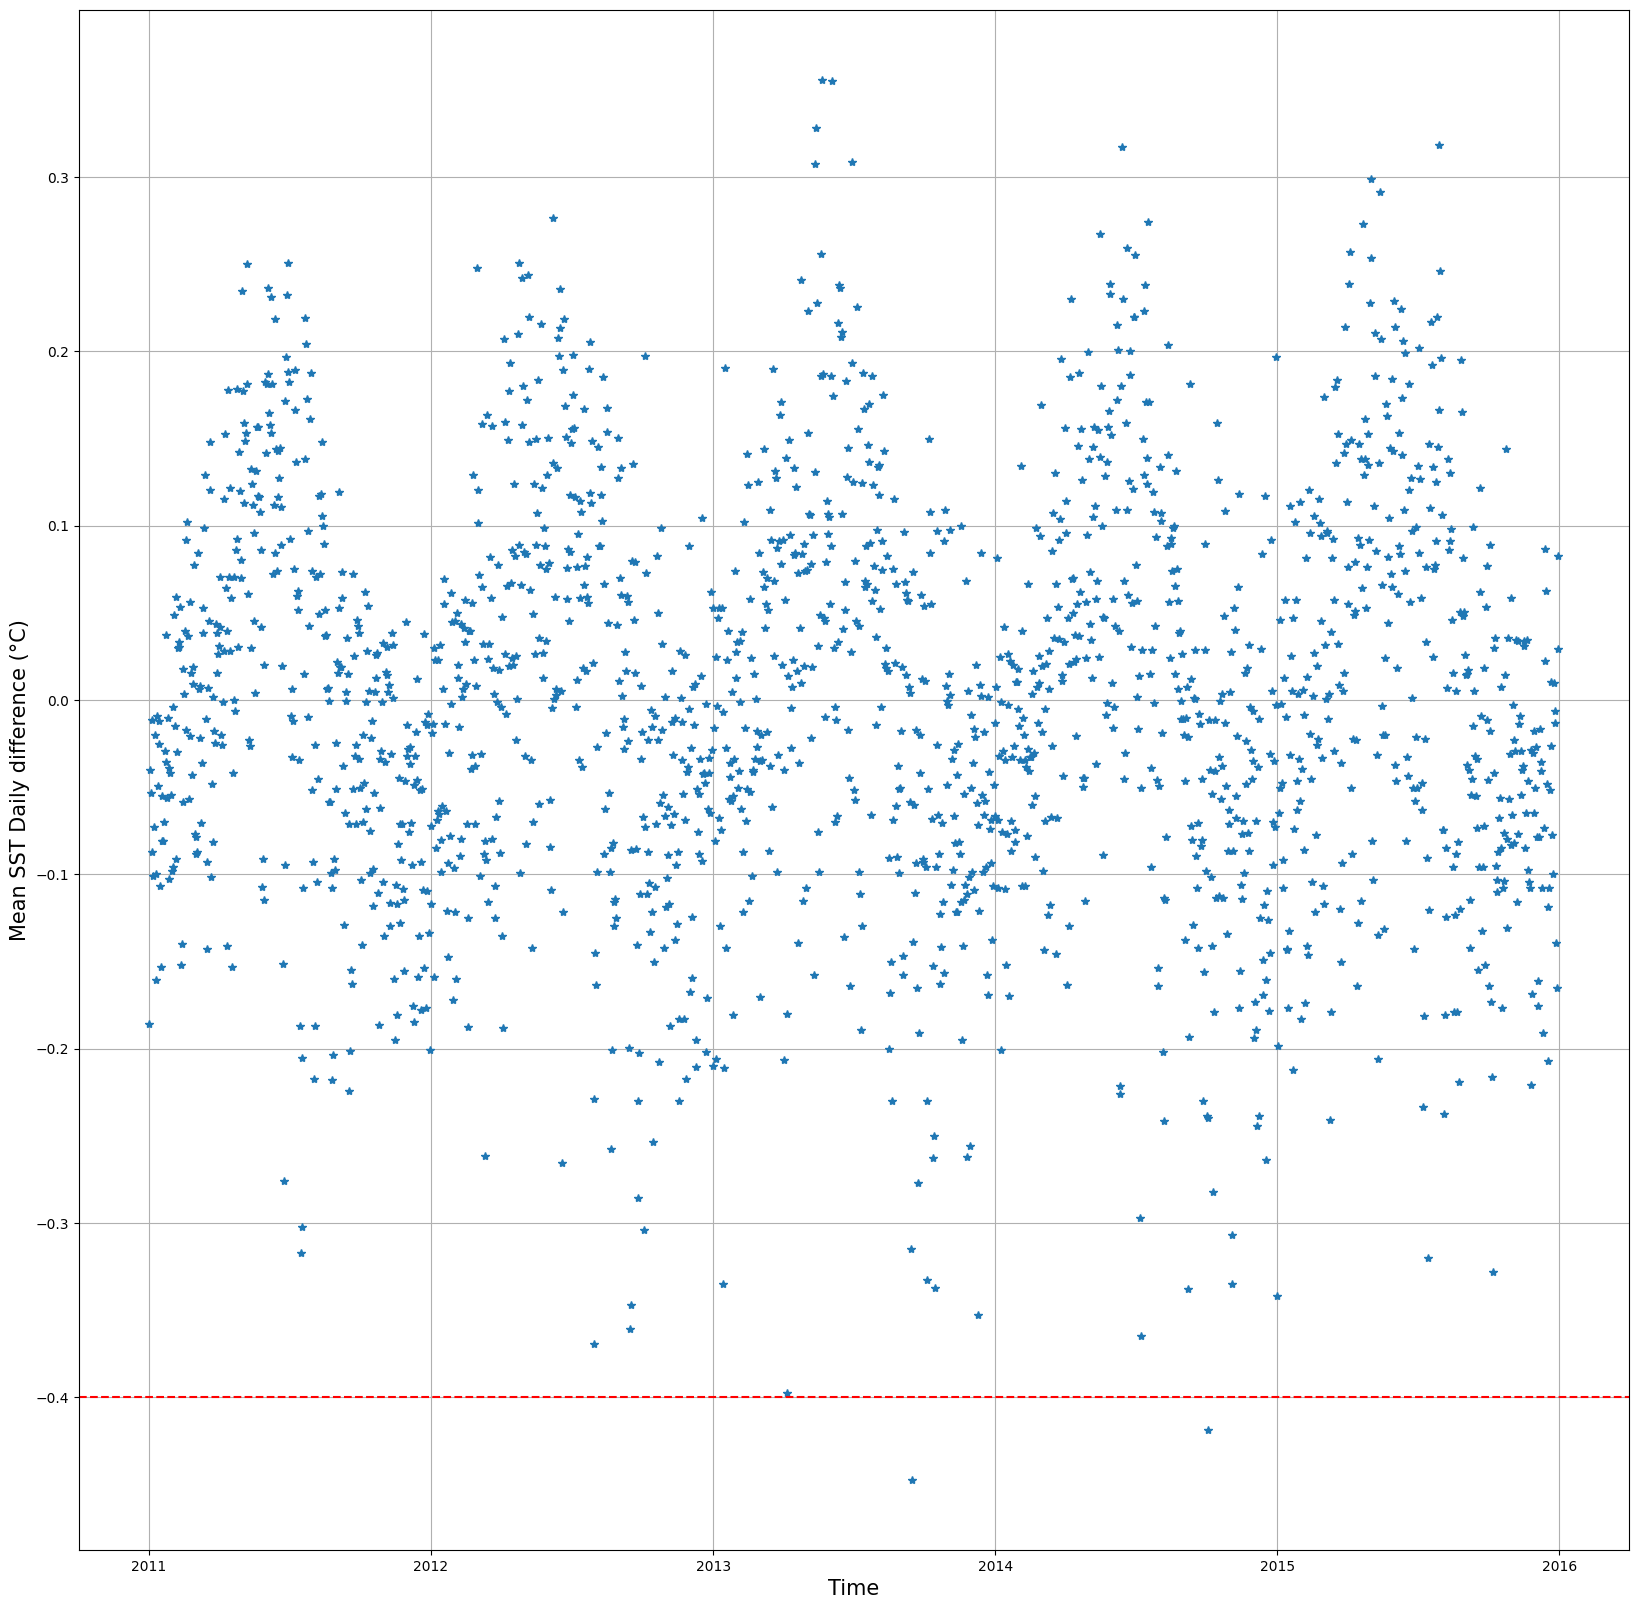

In [ ]:
# plot global SST and SSH time series
sst_diff = output.mean_sst.diff(1)
time_ts=output.groupby(['time'])['time'].mean()
figure()
plot_ts(time_ts-734138+14975,sst_diff,'*','Mean SST Daily difference (°C)')
plt.axhline(-0.4, color='r', linestyle='--', label='Threshold')
plt.grid()

In [ ]:
sst_diff.where(sst_diff < -0.4).dropna()

988    -0.447307
1371   -0.418684
Name: mean_sst, dtype: float64

**Note 3:** We can observe two points which are below the -0.4 °C. The first one is september the 15th 2013, which corresponds with the formation of the Usagi Typhoon. The second one is october the 4th 2014, which corresponds to the Phanfone Typhoon.

**Part 3) Combination of BigQuery and scikit-learn**

Now, we will extract data using BigQuery and apply regressions (using scikit-learn) on these extracted data.

**QUESTION 4**: Model the daily mean of SST in the Mediterranean Sea using a linear tendancy and a one-year seasonal cycle such that: $SST(t)=\alpha_0 + \alpha_1 t + \alpha_2 sin(2\pi\omega t) + \alpha_3 cos(2\pi\omega t)$, with $\omega=\frac{1}{365}$. Then, plot the raw time series and the one produced by the statistical model. Finally, plot the autocorrelation function of the residuals (difference between the raw time series and the estimation made by the statistical model).

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output

time   mean_sst
0     734138.0  17.835287
1     734139.0  17.769646
2     734140.0  17.662914
3     734141.0  17.548694
4     734142.0  17.521793
...        ...        ...
1821  735959.0  18.417702
1822  735960.0  18.358416
1823  735961.0  18.348665
1824  735962.0  18.194399
1825  735963.0  18.055543

[1826 rows x 2 columns]

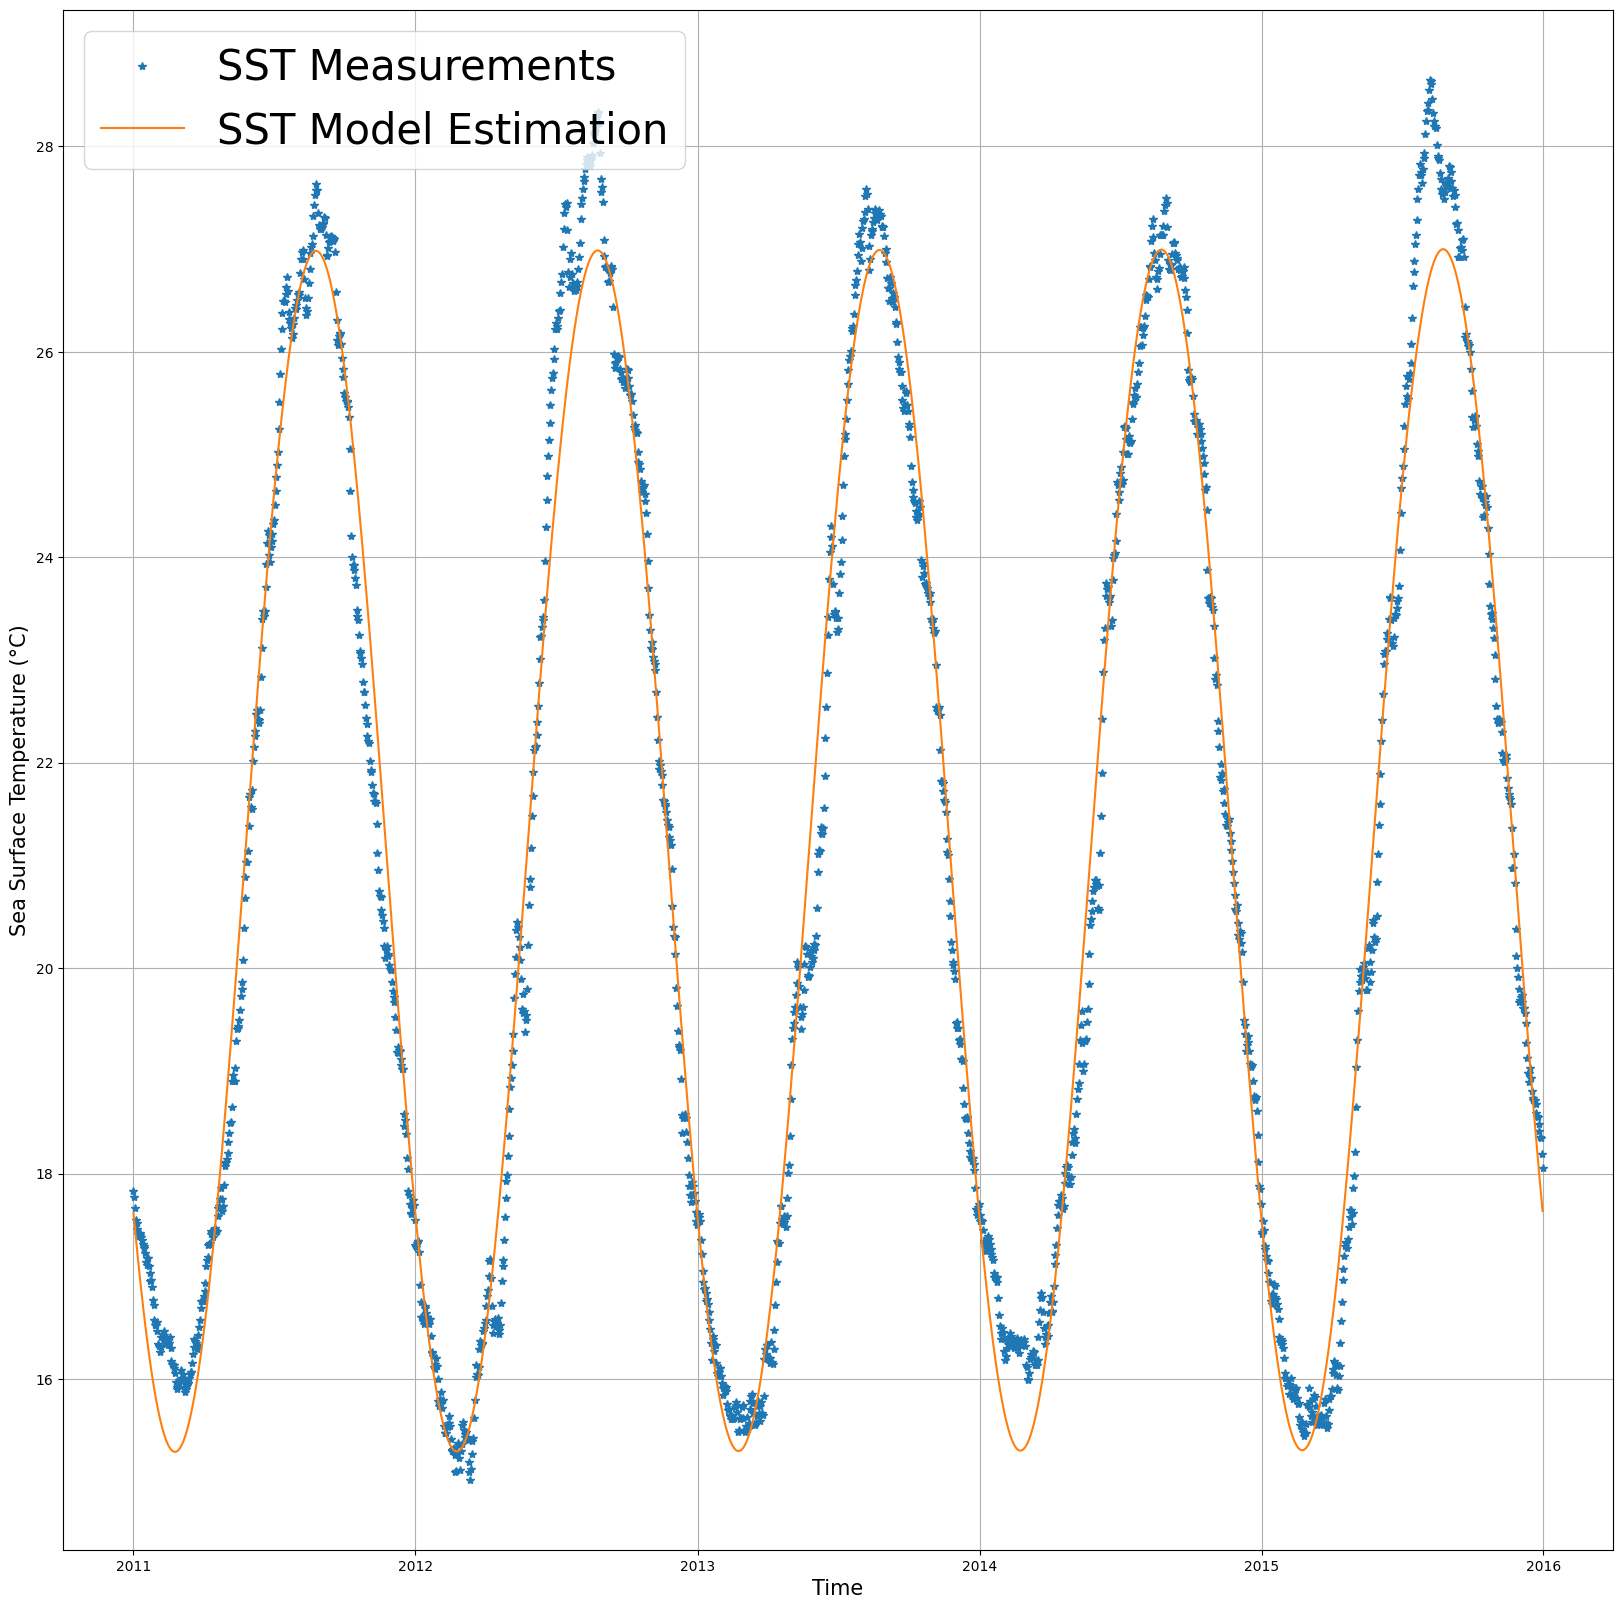

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

time = output.time
mean_sst = output.mean_sst

def SST(t, a0, a1, a2, a3):
  w=1/365
  return a0 + a1*t + a2*np.sin(2*np.pi*w*t) + a3*np.cos(2*np.pi*w*t)


# Initial guess for the parameters
initial_guess = (1.0, 1.0, 1.0, 1.0)  # Replace with your initial estimates

# Perform the curve fitting
params, covariance = curve_fit(SST, time, mean_sst, p0=initial_guess)

sst_estimation = SST(time, params[0], params[1], params[2], params[3])

plot_ts(time-734138+14975,mean_sst,'*','Sea Surface Temperature (°C)')
plot_ts(time-734138+14975, sst_estimation,'-','Sea Surface Temperature (°C)')
plt.legend(["SST Measurements", "SST Model Estimation" ], fontsize=30)
plt.grid()



In [ ]:
params

array([ 1.30855419e+01,  1.09651035e-05, -5.82212940e-01,  5.81584049e+00])

**Note 4:**
The obtained parameters are the following:
- a0  = -136.69 °C
- a1  = 2.18 e-04 °C/day
- a2  = -0.51 °C
- a3  = 4.63 °C

We can observe that a1 is a parameter that models the increase in SST due to global warming.
Furthermore, the model works solely in the vicinity of the provided data since it assumes that the rate of global warming has been constant since the beginning of time. This explains the value of a0 which predicts an SST of -136 °C at t=0 (which corresponds to year 1).


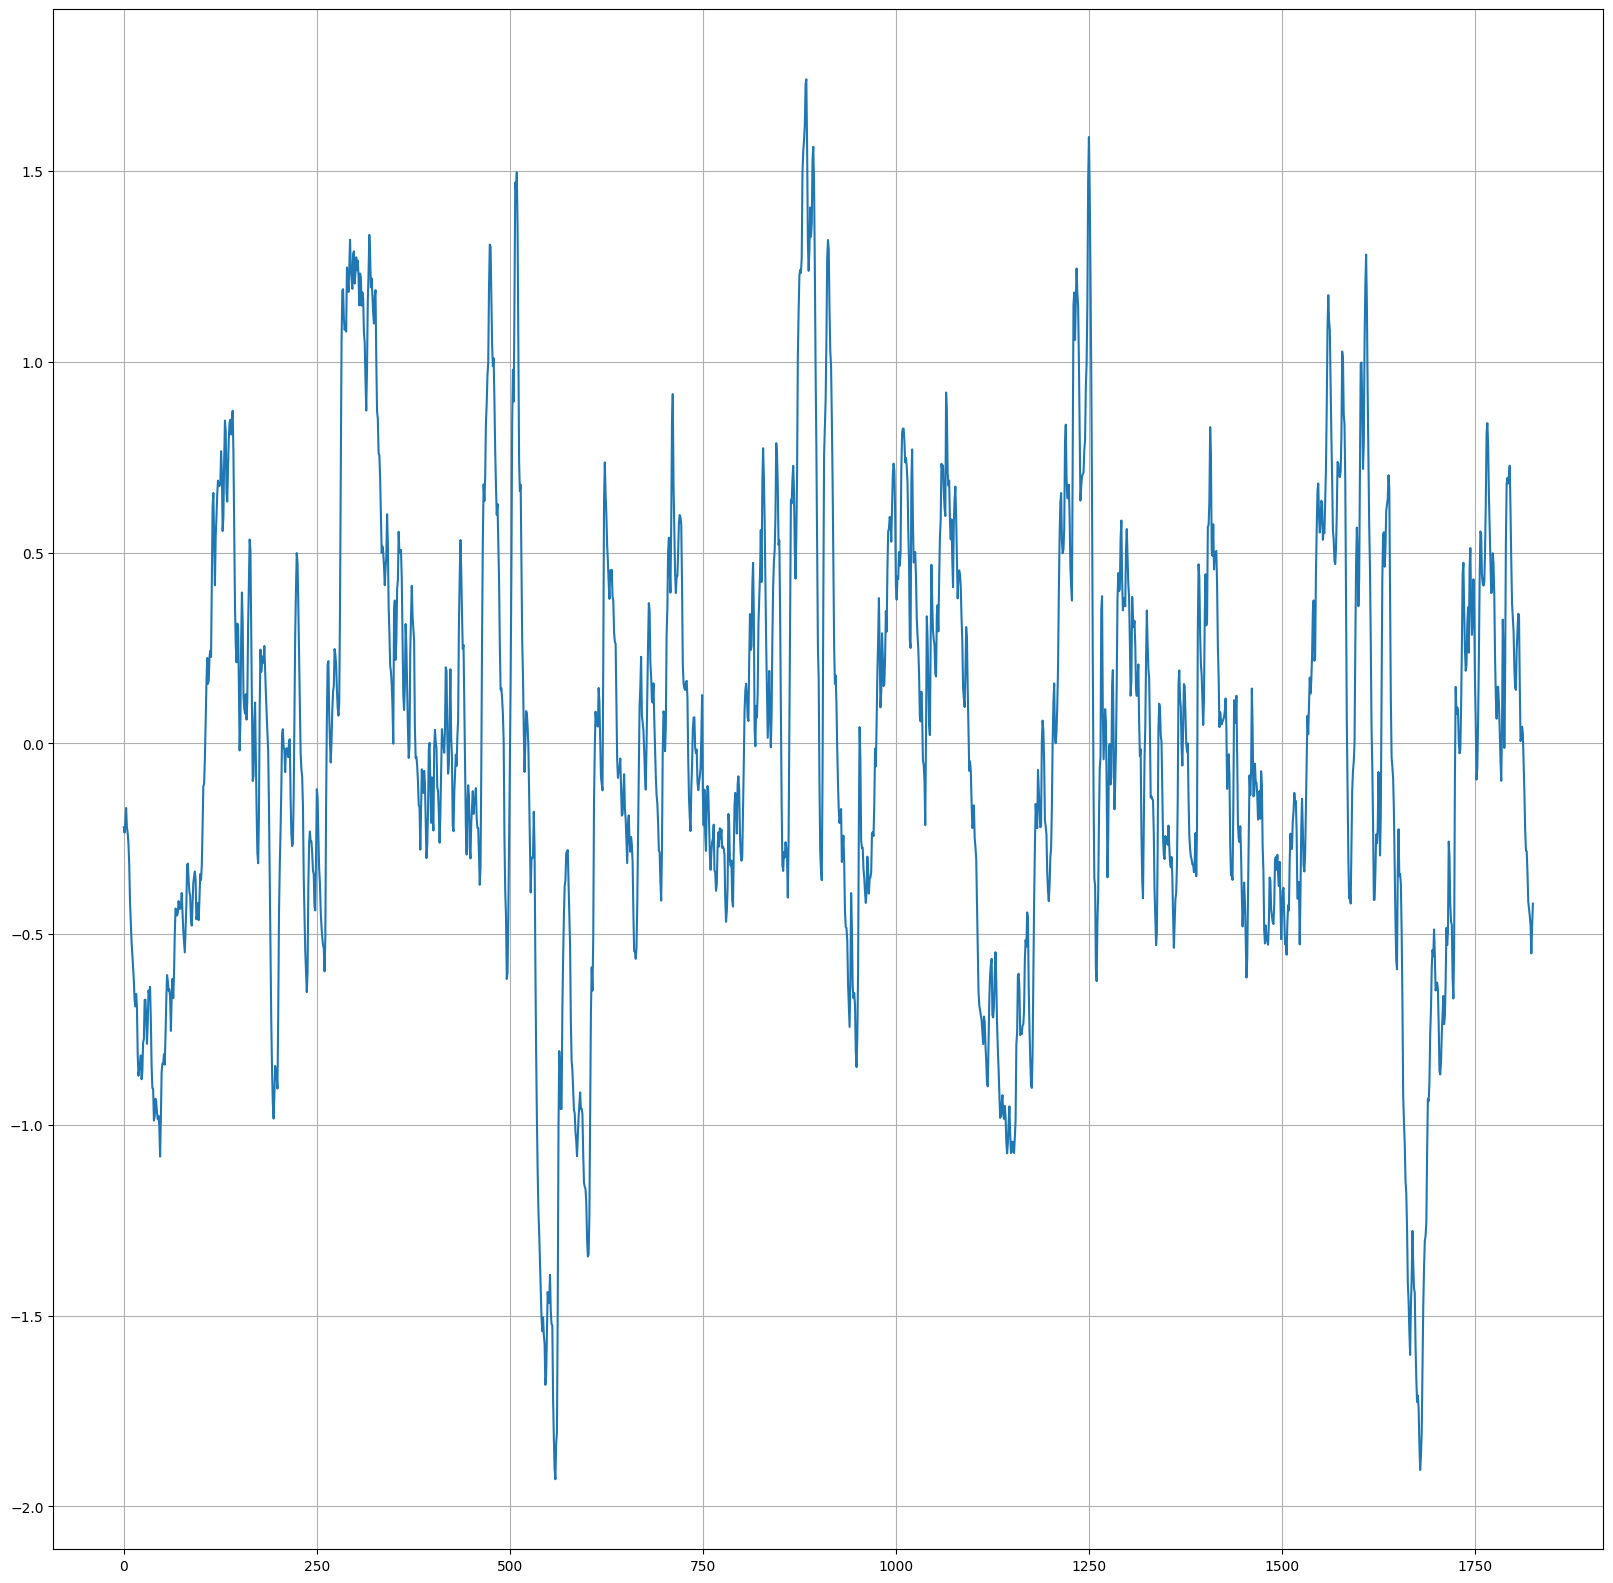

In [ ]:
residual = sst_estimation - mean_sst
plt.plot(residual)
plt.grid()

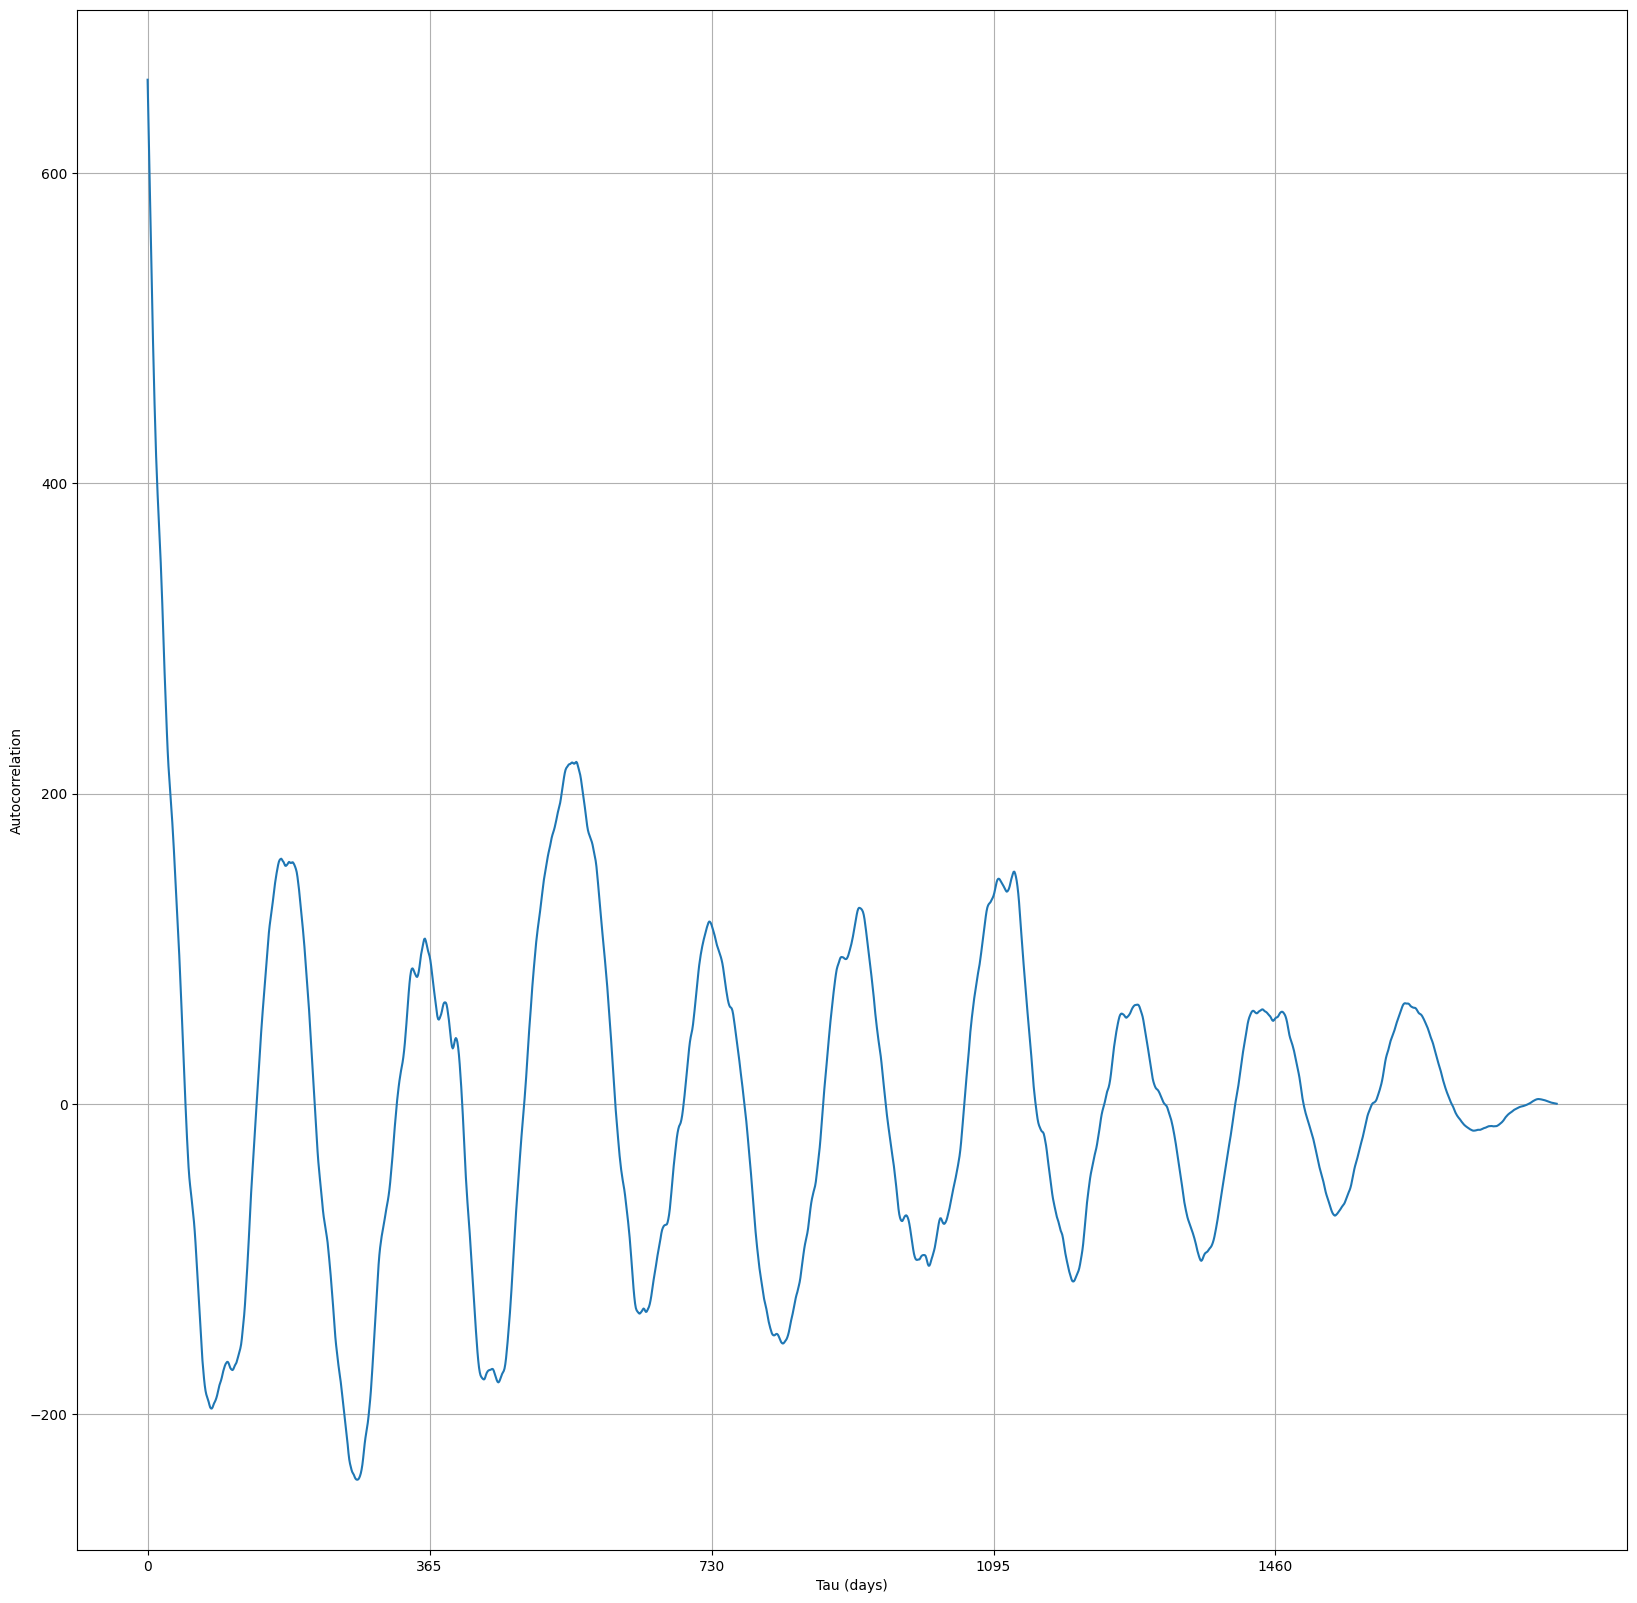

In [ ]:


autocorrelation = np.correlate(residual, residual, mode='full')

plt.plot(autocorrelation[(len(autocorrelation )+1)//2 :])
plt.xticks([365*x for x in range(0, 5)])
plt.ylabel("Autocorrelation")
plt.xlabel("Tau (days)")
plt.grid();
# plot_ts(time-734138+14975, autocorrelation,'*','Sea Surface Temperature (°C)')


Throughout a single season the sign of the residuals tends to stay the same, so the autocorrelation is positive when considering small values of $\tau$.

The periodicity of the curve seems to suggest that the dominant sign of the residual changes with the seasons. Thus, consecutive seasons (e.g. summer and fall) appear to have opposite signs in their residuals, while seasons with an uneven number of intermediary seasons (such as summer and winter or two summers) have same-signed errors.

Additionally, since the autocorrelation is calculated using 0-padding we observe that the module for high $\tau$ values becomes null as we are considering that residuals outside of the studied period are 0.

**QUESTION 5**: Compute the SSH difference between the first day in 2011 and the last day in 2015 for each location in the globe. Then, plot the map of this SSH difference: it shows the sea level rise over different locations. Finally, adjust a regression to model the tendancy of the global mean sea level rise (averaged over all the location) and plot the prediction for the horizon 2100.

In [ ]:
%%bigquery output --project alert-ground-261008

SELECT lon, lat, ssh_2011, ssh_2015

FROM

(SELECT lon, lat, avg(ssh) AS ssh_2011
FROM bdo2020.bdo2020.2011_2015 AS data
WHERE data.time = 734138 # Time for the 1st day of jan. 2011
GROUP BY lon, lat) AS data_2011

INNER JOIN

(SELECT lon AS lon_2015, lat AS lat_2015, avg(ssh) AS ssh_2015
FROM bdo2020.bdo2020.2011_2015 AS data
WHERE data.time = 735962 # Time for the 31st day of dec. 2015
GROUP BY lon, lat) AS data_2015

ON lon = lon_2015 AND lat = lat_2015

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output

lon     lat  ssh_2011  ssh_2015
0       173.375 -73.625   -1.2122   -1.2848
1       172.625 -73.375   -1.2084   -1.2533
2       246.875 -73.125   -1.1053   -1.1883
3       176.875 -72.625   -1.2043   -1.2025
4       173.375 -72.375   -1.2194   -1.2705
...         ...     ...       ...       ...
531830  359.875  75.125   -0.5394   -0.4397
531831   24.375  75.375   -0.3405   -0.1914
531832   34.875  76.875   -0.2978   -0.1904
531833   35.125  76.875   -0.2990   -0.1901
531834   35.375  76.875   -0.3006   -0.1895

[531835 rows x 4 columns]

In [ ]:
data_2011 = output[['lat', 'lon', 'ssh_2011']]
data_2015 = output[['lat', 'lon', 'ssh_2015']]

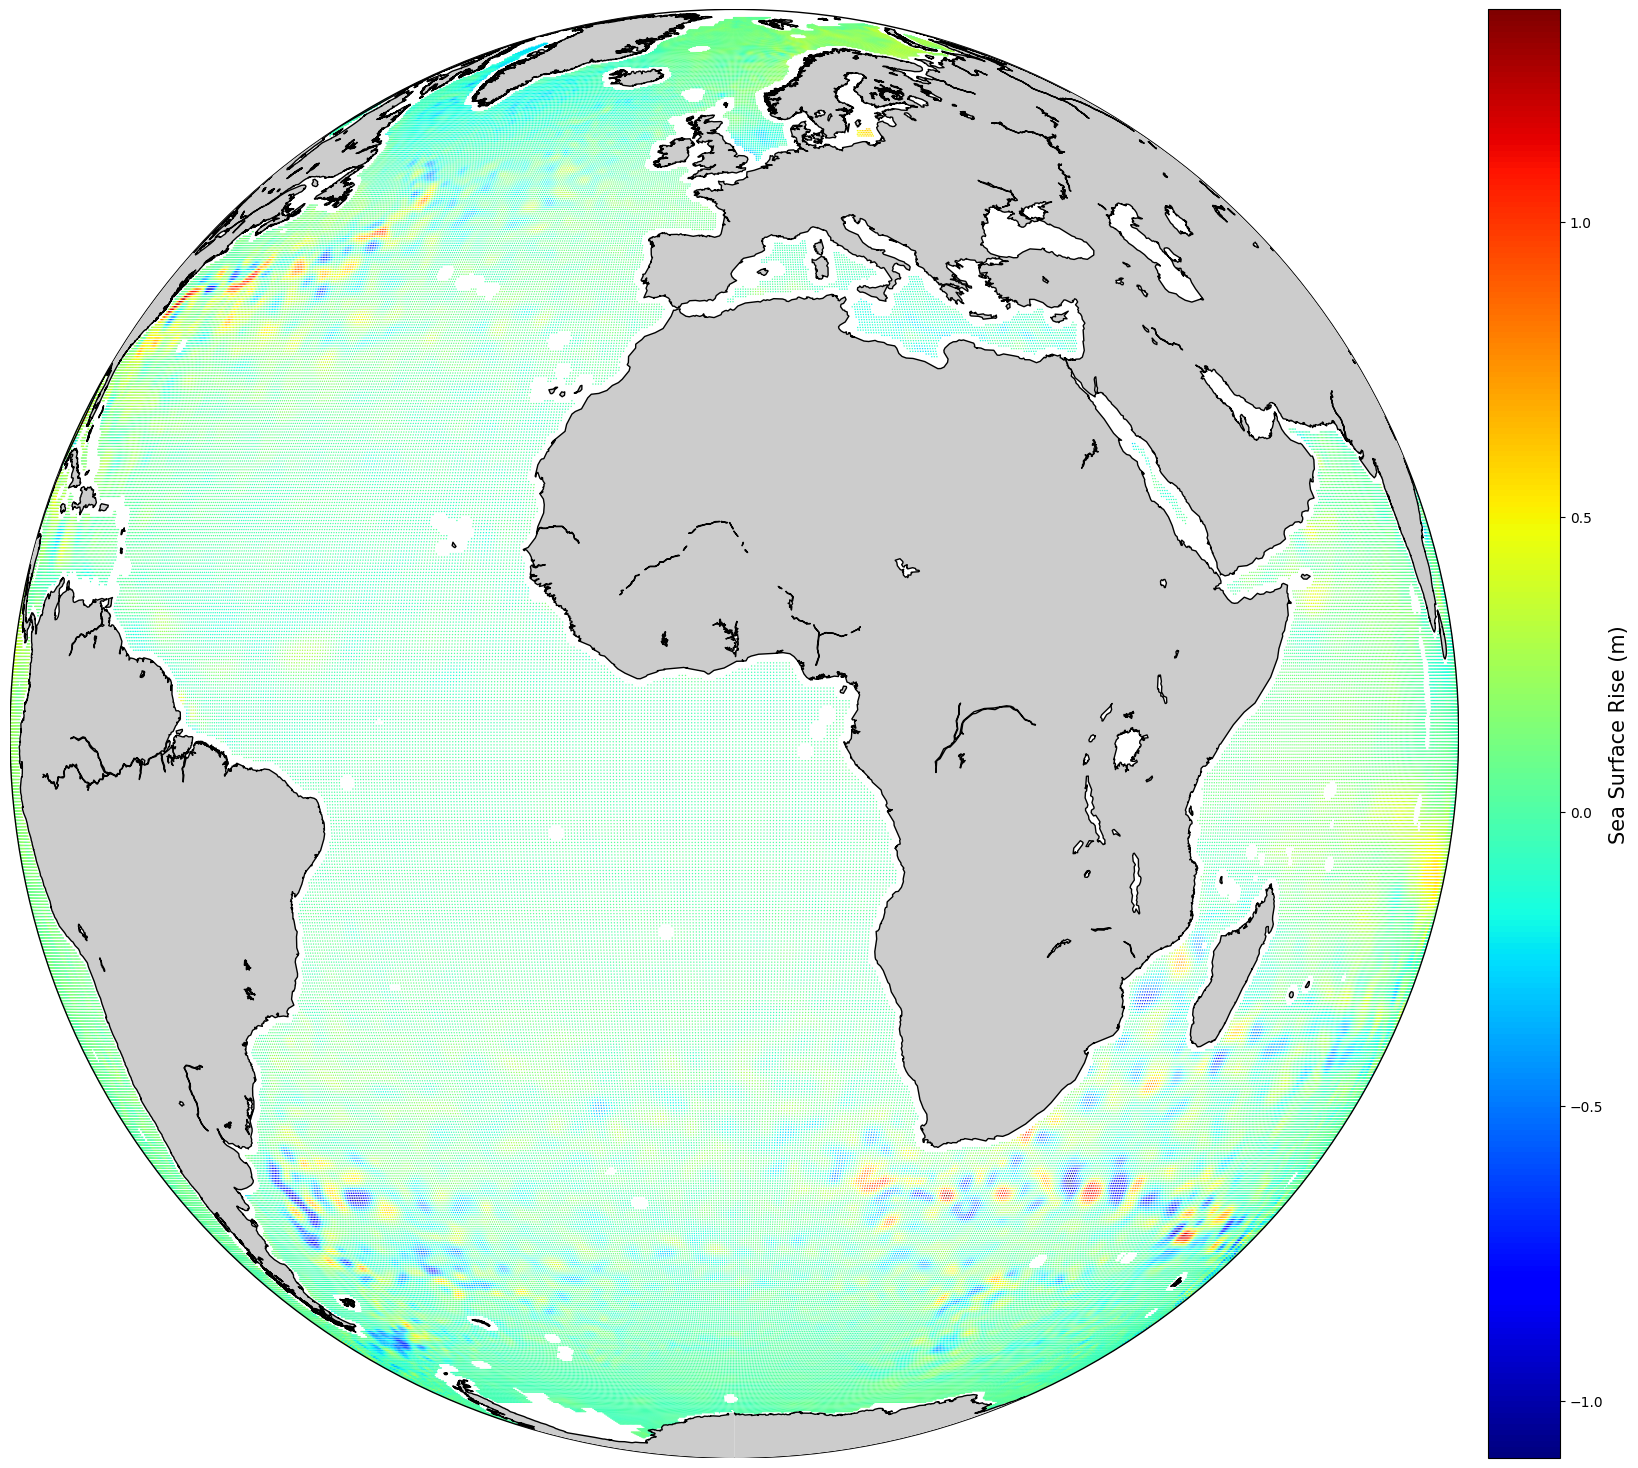

In [ ]:
slr = data_2015.ssh_2015 - data_2011.ssh_2011
plot_im(output.lon, output.lat, slr, 1, 'Sea Surface Rise (m)')

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.2011_2015
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output

time  mean_ssh
0     734138.0  0.310544
1     734139.0  0.309639
2     734140.0  0.307853
3     734141.0  0.307104
4     734142.0  0.305583
...        ...       ...
1821  735959.0  0.337428
1822  735960.0  0.336071
1823  735961.0  0.335014
1824  735962.0  0.334539
1825  735963.0  0.334250

[1826 rows x 2 columns]

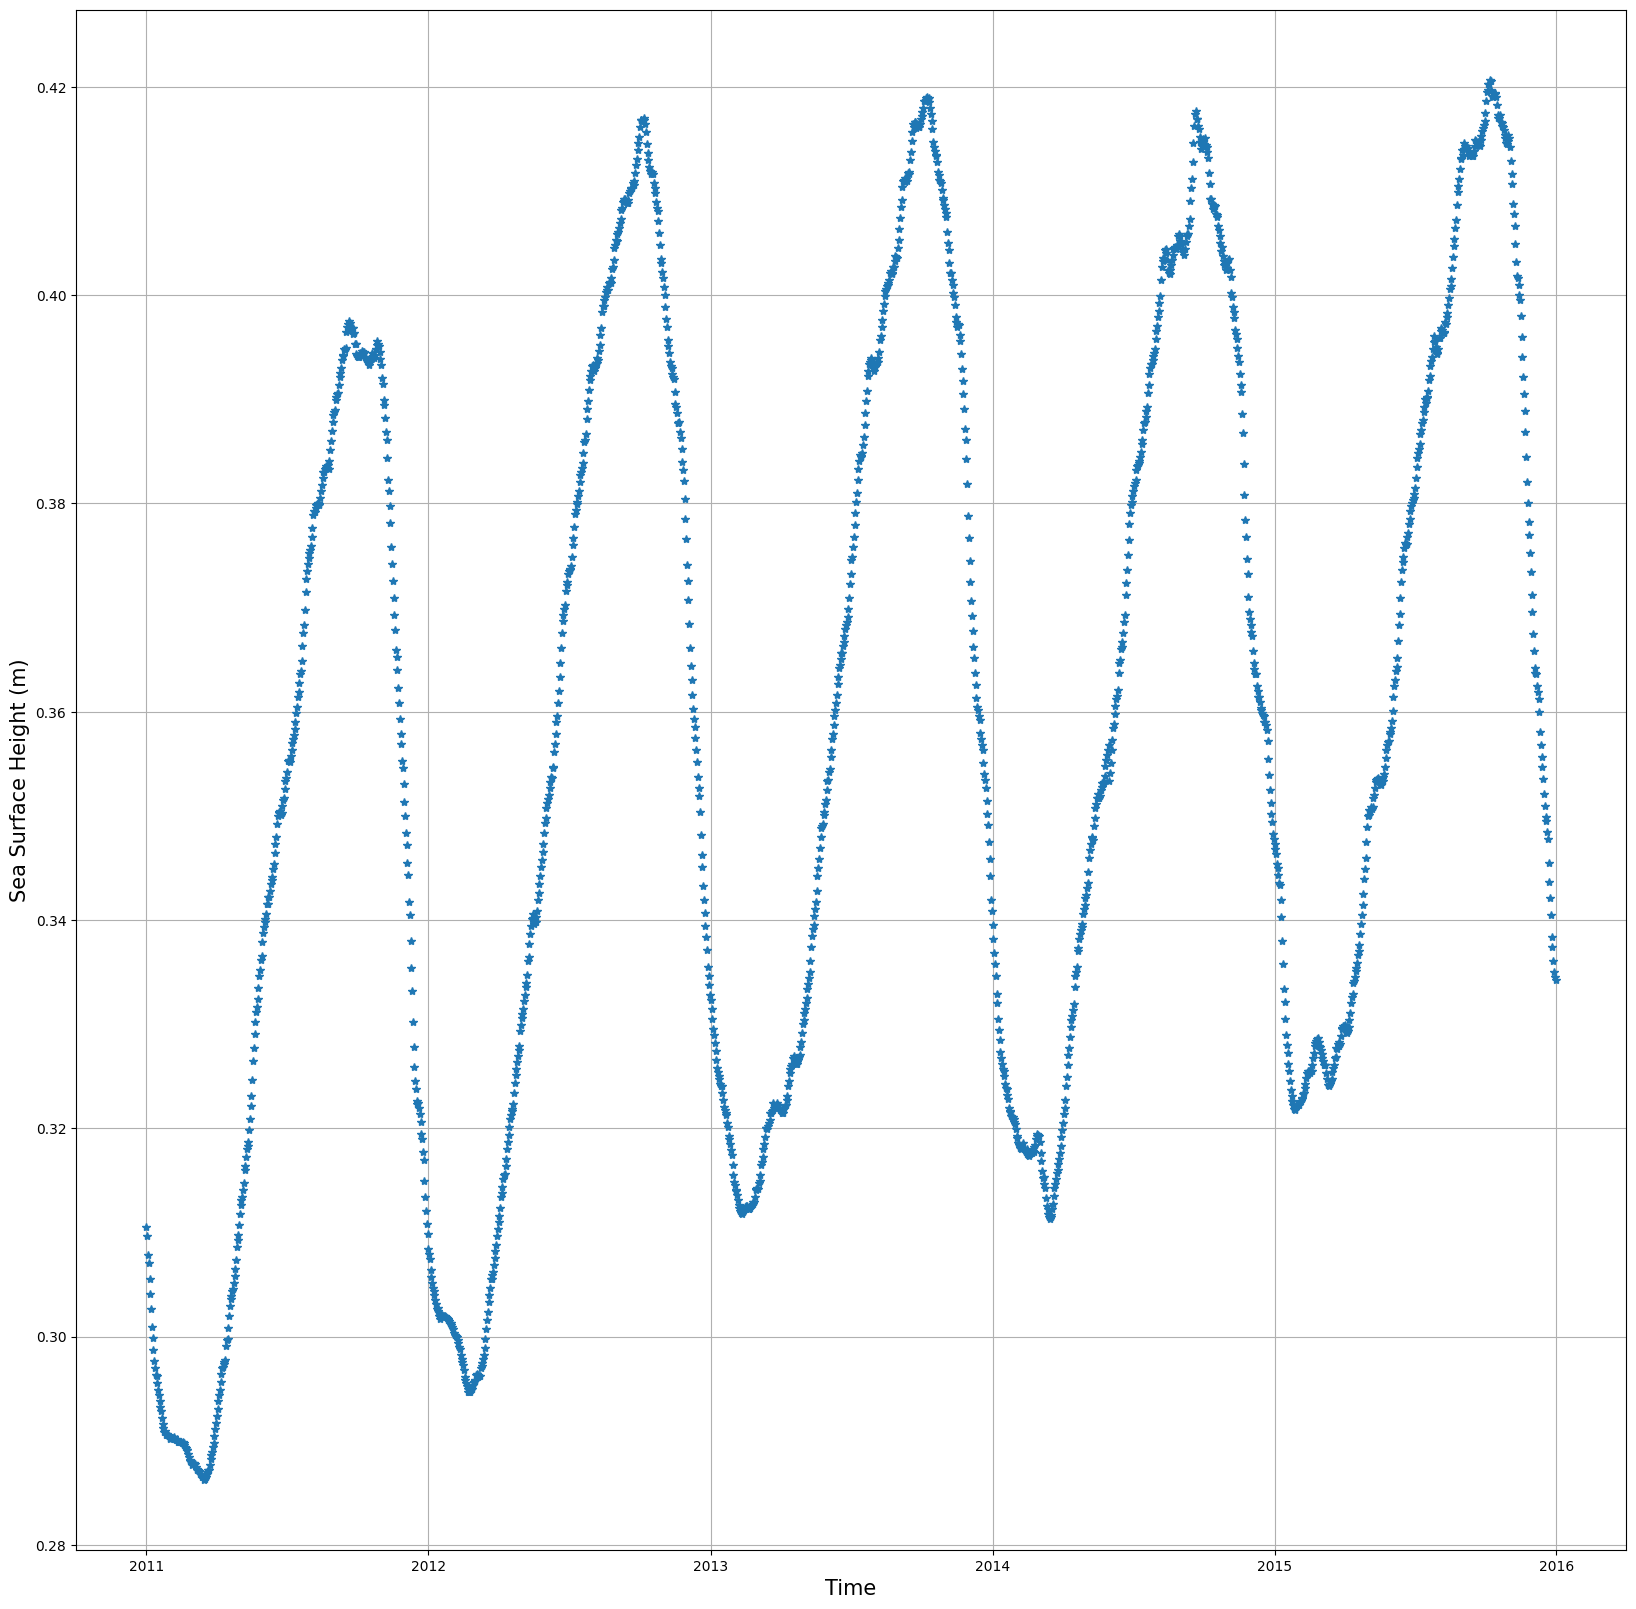

In [ ]:
time = output.time
mean_ssh = output.mean_ssh

plot_ts(time-734138+14975, mean_ssh,'*','Sea Surface Height (m)')
plt.grid()


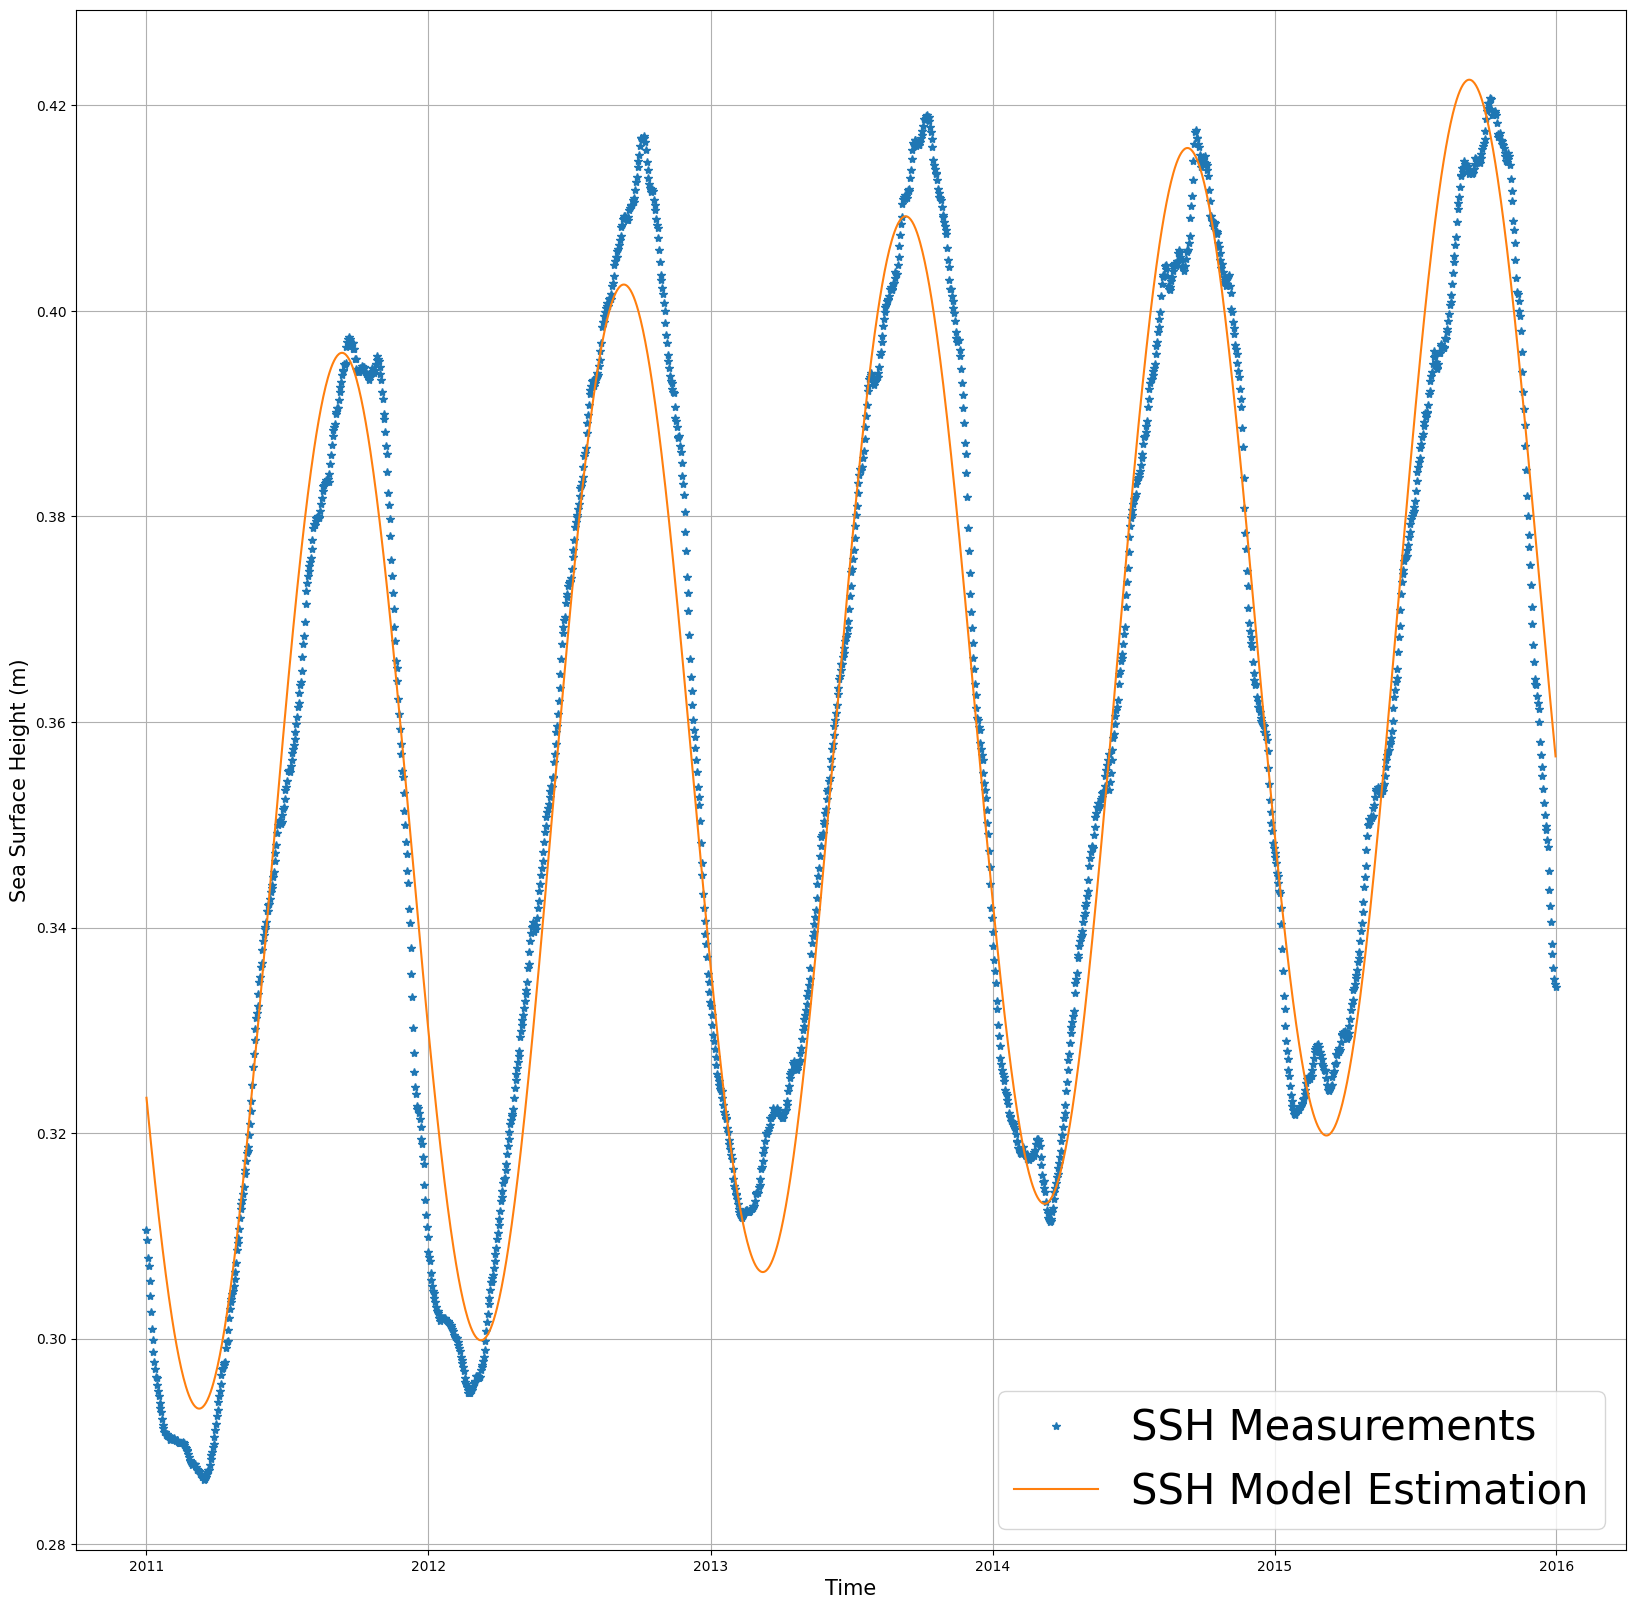

In [ ]:
import numpy as np
from scipy.optimize import curve_fit


def SSH(t, a0, a1, a2, a3):
  w=1/365
  return a0 + a1*t + a2*np.sin(2*np.pi*w*t) + a3*np.cos(2*np.pi*w*t)


# Initial guess for the parameters
initial_guess = (1.0, 1.0, 1.0, 1.0)  # Replace with your initial estimates

# Perform the curve fitting
params, covariance = curve_fit(SSH, time, mean_ssh, p0=initial_guess)

ssh_estimation = SSH(time, params[0], params[1], params[2], params[3])

plot_ts(time-734138+14975,mean_ssh,'*','Sea Surface Height (m)')
plot_ts(time-734138+14975, ssh_estimation,'-','Sea Surface Height (m)')
plt.legend(["SSH Measurements", "SSH Model Estimation" ], fontsize=30)
plt.grid()



In [ ]:
params[1] * 100 * 365 # Centimeters of sea level rise per year

0.6644250004815221

**Note 5:** Since SST and SSH are strongly correlated, we chose to fit the same model to our SSH data. The model shows a good fit for the available period, correctly representing seasonal trends.

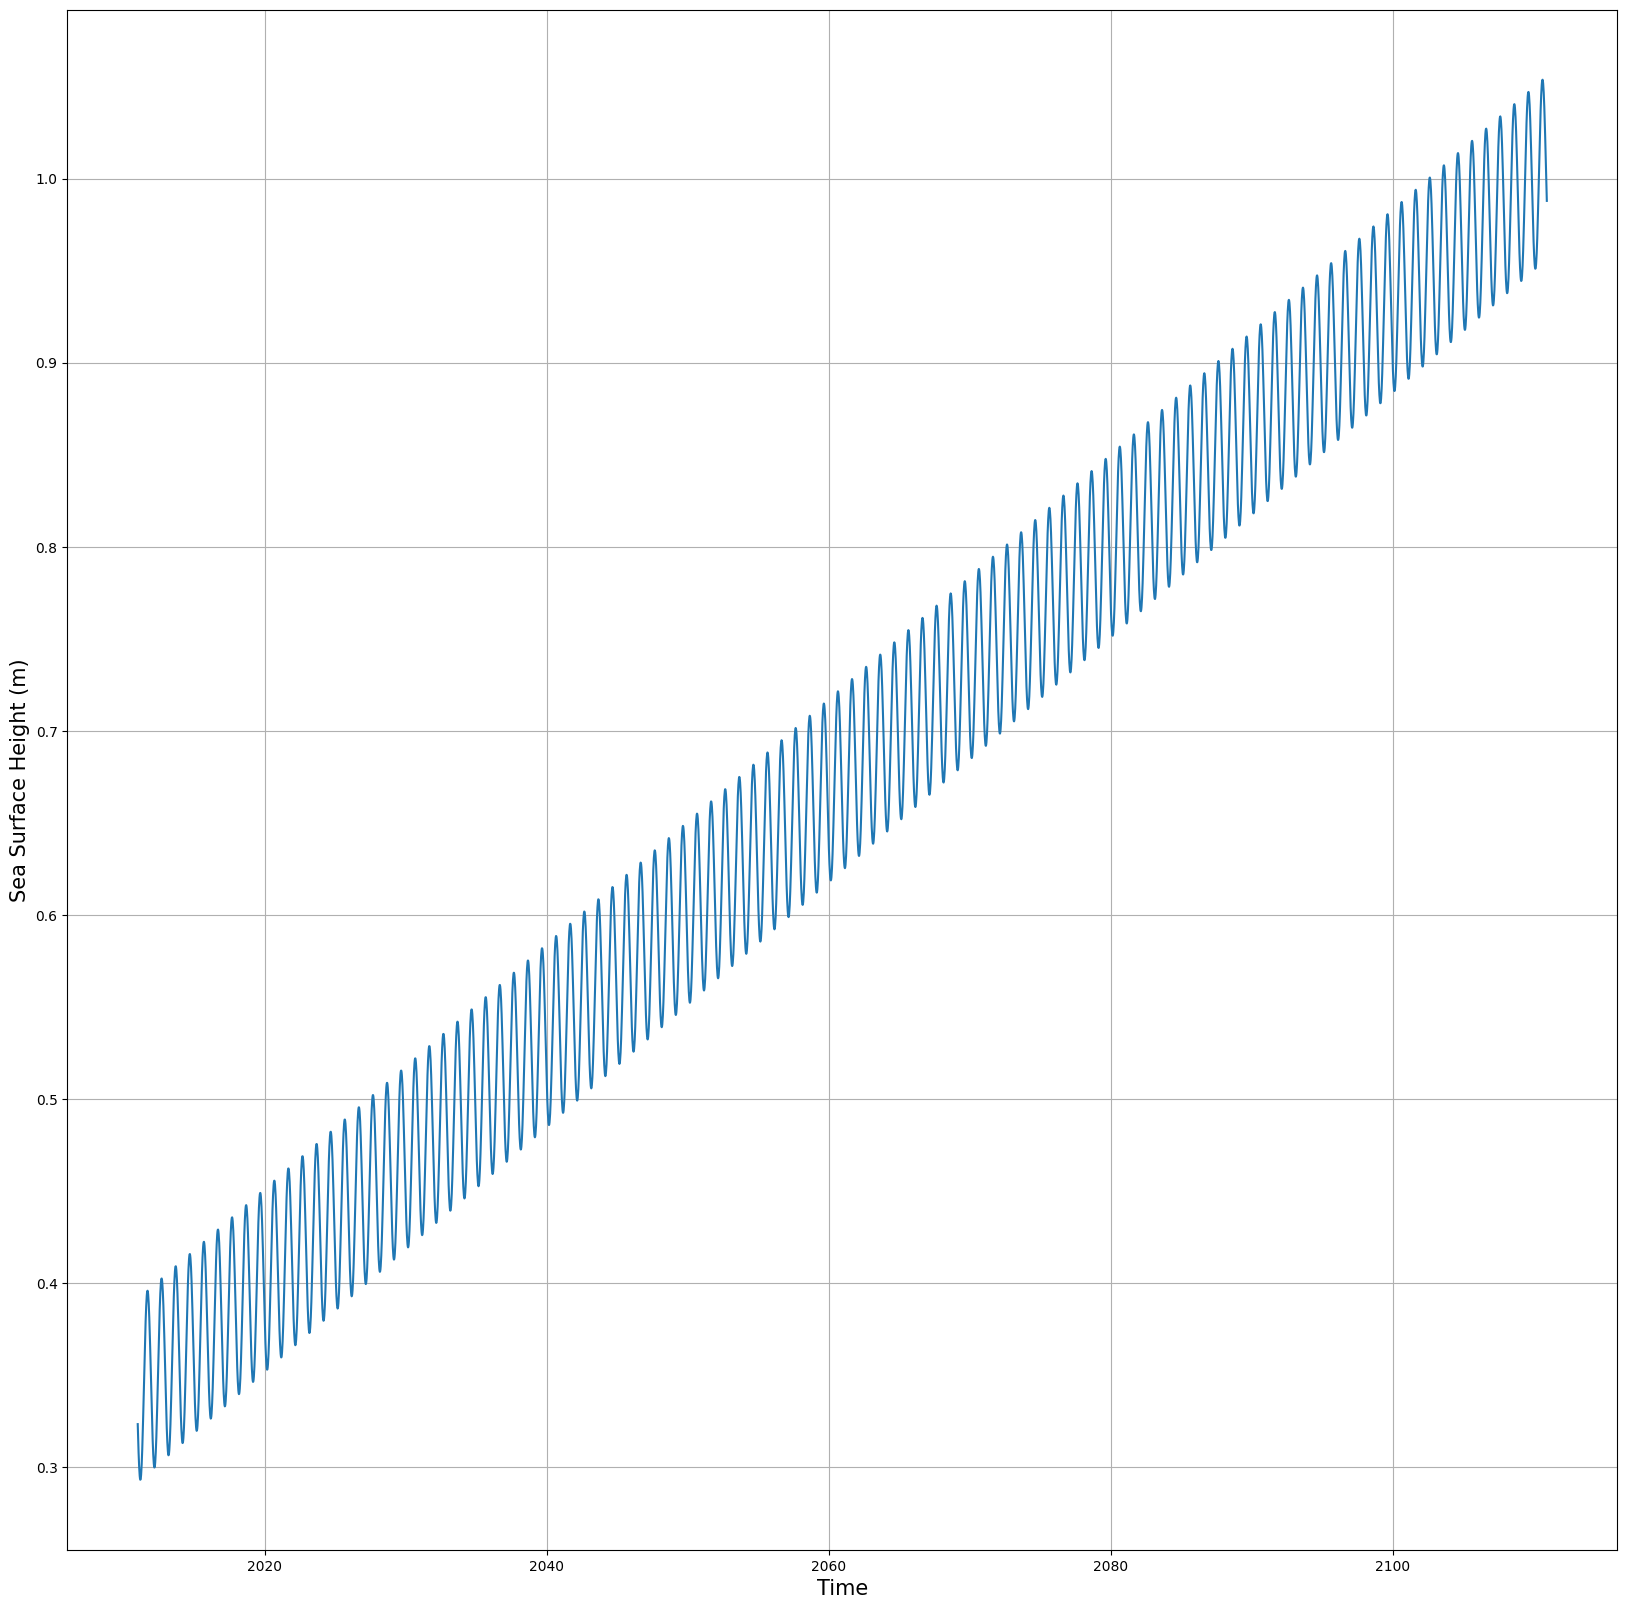

In [ ]:
time_100 = np.linspace(time[0], time[0]+365*100, 5000)
ssh_estimation_100 = SSH(time_100, params[0], params[1], params[2], params[3])

plot_ts(time_100-734138+14975,ssh_estimation_100,'-','Sea Surface Height (m)')
plt.grid()


**Note 6:** We observe that according to our model, the mean sea level rise will be of around 0.9m by the end of the century. Although the considered period is much shorter than the usual timescale used in climatology (30 years) it still illustrates the point that many low lying areas will risk disappearing under the tides if no action is taken to combat the climate crisis.

